# End to End Inference Tutorial
Here we implement a complete end-to-end use of paltas. This notebook is intended as a 'minimal reproducible example', and thus doesn't use the full extent of the package, but should be a useful starting point. \
A number of the code-blocks simply run command-line instructions. This is intentional, as paltas is designed to run in the command-line. Furthermore, running such command-line statements allows easier transfer to remote computing clusters/parallelisation.


# Goals

1. To be able to implement a simple end-to-end example of Paltas
2. To understand how each of the packages inter-communicate, and which packages need to be run (and when), to perform hierarchichal inference.

# Import Packages
Here we import the required packages and define the training and model directories (where the training images and model weights are stored, respectively).\
The '/home/runner/work' referred to here is required to run this notebook as a Github Action, but should be changed to a prefered directory when running this notebook locally.\
Although tensorflow, emcee and ipython do not form part of the requirements for paltas, they are required for this notebook.

In [103]:
import os
from importlib import import_module 
#paltas_directory = './'
#training_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/' #For github actions
#model_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
#training_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files' #For NERSC
#model_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files'
#paltas_directory = '/global/u2/p/phil1884/paltas/'

analysis_folder = 'paltas.Analysis.AnalysisConfigs'
training_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/' #For Glamdring (in extraspace)
training_config_directory = f'{analysis_folder}.train_config_LSST_Lenspop_no_subtr' #Keep Updated!
test_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/'
model_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/'

# training_directory = '/mnt/zfsusers/hollowayp/paltas/extraspace_files/Example_LP_12/'
# test_directory = '/mnt/zfsusers/hollowayp/paltas/extraspace_files/Example_LP_12/'
# model_directory = '/mnt/zfsusers/hollowayp/paltas/extraspace_files/Example_LP_12/'

# training_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_Eu_2/'
# test_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_Eu_2/'
# model_directory = '/mnt/extraspace/hollowayp/paltas_data/Example_Eu_2/'

paltas_directory = '/mnt/zfsusers/hollowayp/paltas/'
os.chdir(paltas_directory)

training_config = import_module(training_config_directory)
learning_params = training_config.learning_params
batch_size = training_config.batch_size
flip_pairs = training_config.flip_pairs
n_epochs = training_config.n_epochs
random_seed = training_config.random_seed
norm_images = training_config.norm_images
loss_function = training_config.loss_function
model_type = training_config.model_type
img_size = training_config.img_size
npy_folders_train = training_config.npy_folders_train

from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
from IPython.display import display,Pretty
import matplotlib.patches as mpatches
import matplotlib.pyplot as pl
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import h5py
import glob
import sys
import datetime
random_seed = 4
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

title_dict = {
    'main_deflector_parameters_gamma':'Density Slope, $\gamma$',
    'main_deflector_parameters_theta_E':'Einstein radius, $\\theta_E$',
    'main_deflector_parameters_e1':'Lens Ellipticity, $e_1$',
    'main_deflector_parameters_e2':'Lens Ellipticity, $e_2$',
    'main_deflector_parameters_gamma1':'Lens Shear,$\gamma_1$',
    'main_deflector_parameters_gamma2':'Lens Shear,$\gamma_2$',
    'main_deflector_parameters_center_x':'Lens Center, x',
    'main_deflector_parameters_center_y':'Lens Center, y',
    'lens_light_parameters_mag_app':'$mag_i$ (Lens)',
    'source_parameters_mag_app':'$mag_i$ (Source)',
    'main_deflector_parameters_z_lens':'$z_L$',
    'source_parameters_z_source':'$z_S$',
    'lens_light_parameters_R_sersic':'Lens Light: $R_{eff}$',
    'source_parameters_R_sersic':'Source Light: $R_{eff}$',
    'lens-source_separation':'Lens-Source Separation',
    'Magnification':'Magnification'
}

In [ ]:
#Example_LP_9: Lenspop, with fixed lens centre and gamma=2. ~400,000 training subjects
#=> Training via 731034.out => Validation loss became infinite (perhaps set was too small?)
#Example_LP_10: Lenspop, with x,y center and gamma variation (so NN can learn these).
#=> Training via 731199 with larger validation set (=5000).
#Example_LP_14: Lenspop, including 100,000 RSP images (with correct variance).
#Example_LP_15: Duplicate of Example_LP_12 (Lenspop with no RSP), but with only 100k training images not 500k
#Example_LP_16: Duplicate of Example_LP_15 (and _12) but with 1m training images.
#Example_Eu_2: Euclid Lenspop, no RSP. 

In [14]:
#from training_directory.training import config_LensPop
import importlib.util
import sys
spec = importlib.util.spec_from_file_location("config_LensPop", training_directory+'/training/2/config_Lenspop.py')
foo = importlib.util.module_from_spec(spec)
sys.modules["config_LensPop"] = foo
spec.loader.exec_module(foo)
foo.save_noise


False

Flux 1323.8734125377332 Mag: 20.045383849296392
Flux 1345.1638318474406 Mag: 20.02806204578171
Flux 1069.8486933782906 Mag: 20.27669409849118
Flux 1691.6087385388992 Mag: 19.779250200085276
Flux 1212.1481767774949 Mag: 20.14111071852801
Flux 1466.1303592795425 Mag: 19.93456853297052
Flux 1114.5270755820889 Mag: 20.232273441483215
Flux 1201.001357496043 Mag: 20.151141254280606
Flux 1442.2513599872564 Mag: 19.952397607116815
Flux 1405.9029075158708 Mag: 19.980111677284242


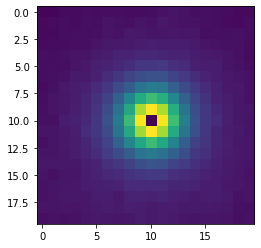

In [183]:
import glob
npy_files = glob.glob('/mnt/zfsusers/hollowayp/paltas/mag_npy_files/image*npy')
for n in range(len(npy_files)):
    img = np.load(npy_files[n])[40:60,40:60]
    pl.imshow(img)
    print('Flux',np.sum(img),'Mag:',27.85-2.5*np.log10(np.sum(img)))

In [487]:
#from load_h5_file import load_h5_file
LP14 = load_h5_file('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/validation/1/')
#RSP_im = load_h5_file('/mnt/zfsusers/hollowayp/paltas/RSP_Coadd_Files_100000/38_Nexp_data.h5')
np.sum(np.isnan(LP14))

Loading /mnt/extraspace/hollowayp/paltas_data/Example_LP_14/validation/1/image_data.h5


0

In [9]:
#!python3 -m pip install arviz --upgrade
import arviz as az
az.style.use("arviz-plasmish")
#az.style.available

# Load Kernel

In [ ]:
import os
import dill
paltas_directory = '/mnt/zfsusers/hollowayp/paltas/'
os.chdir(paltas_directory)
dill.load_session('/mnt/zfsusers/hollowayp/paltas/notebooks/End_to_End_Example_Inference_Working_File.db')

# Save Kernel

In [ ]:
import dill
#dill.dump_session('/mnt/zfsusers/hollowayp/paltas/notebooks/End_to_End_Example_Inference_Working_File.db')

# Generate Images
We start by generating lensed images divided into training and validation sets. The images are saved within one h5 file for each run of generate.py. We'll first look at the configuration file used to determine the properties of the generated images:

In [ ]:
display(Pretty(glob.glob(f'{training_directory}/training/1/config*')[0]))

We then run the image generation:

In [ ]:
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/training/1 --n 100 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/validation/1 --n 100 --tf_record --h5

# Plot the Generated Distributions

In [6]:
train_folders_list = glob.glob(f'{training_directory}/training/**/metadata.csv',recursive=True)
for ii,m_i in tqdm(enumerate(train_folders_list)):
    if ii==0:
        generated_image_params_db = pd.read_csv(f'{train_folders_list[ii]}')
    else:
        generated_image_params_db = pd.concat([generated_image_params_db,
                                pd.read_csv(f'{train_folders_list[ii]}')],ignore_index=True)

try:
    generated_image_params_db=generated_image_params_db.drop(['cosmology_parameters_cosmology_name',
                                        'detector_parameters_background_noise',
                                        'detector_parameters_exposure_time',
                                        'detector_parameters_magnitude_zero_point',
                                        'detector_parameters_num_exposures',
                                        'detector_parameters_pixel_scale',
                                        'detector_parameters_read_noise',
                                        'detector_parameters_sky_brightness',
                                        'lens_light_parameters_output_ab_zeropoint',
                                        'main_deflector_parameters_M200',
                                        'detector_parameters_ccd_gain',
                                        'psf_parameters_fwhm',
                                        'psf_parameters_psf_type',
                                        'seed',
                                        'source_parameters_output_ab_zeropoint',
                                        'main_deflector_parameters_dec_0',
                                        'main_deflector_parameters_ra_0',
                                        'source_parameters_n_sersic',
                                        'lens_light_parameters_n_sersic'],axis=1)
except:
        pass


0it [00:00, ?it/s]

10it [00:10,  1.00s/it]


In [ ]:
#corner.corner(generated_image_params_db,labels=generated_image_params_db.columns)
corner.corner(generated_image_params_db[learning_params],
              labels=[elem.replace('main_deflector_parameters_','') for elem in learning_params])
pl.show()

# Train Model
The neural network is then trained. The --h5 indicates that the images were originally saved as h5 files, and should be retrieved as such. Again, most of the work is done by the configration file, so we'll inspect that first. We define the learning parameters (the lens properties the network should determine), in this file - we chose the Einstein radius, shear, power-law slope, position and ellipticity in this example. 

In [ ]:
display(Pretty("./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py"))

In [ ]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py --h5

# Generate Model Predictions
Having trained the model, we locate the filename of the final epoch (this can be hardcoded instead if desired).

In [40]:
import sys
from importlib import reload
try: reload(sys.modules['load_model'])
except: pass
from load_model import load_model,load_model_weights_list,return_final_epoch_weights,return_list_of_weight_files

final_weights_filename = return_final_epoch_weights(model_directory)

def retrieve_training_prior():
    prior_path = glob.glob(f'{training_directory}/**/norm*',recursive=True)[0]
    print(f'Retrieving prior path from {prior_path}')
    training_prior_db = pd.read_csv(prior_path)
    return training_prior_db

prior_db = retrieve_training_prior()
prior_db_indx = prior_db.set_index(prior_db['parameter'])
print('NOTE: This training prior should really encompass all the training images, not just a subset (i.e. not just one folder of them)')

Found ['12--2.68.h5', '42--4.58.h5', '13--2.61.h5', '36--3.97.h5', '33--4.28.h5', '79--5.00.h5', '78--5.05.h5', '22--3.63.h5', '68--4.94.h5', '25--3.61.h5', '56--4.72.h5', '32--3.62.h5', '08--1.68.h5', '64--5.02.h5', '43--4.54.h5', '58--4.90.h5', '65--5.03.h5', '27--3.75.h5', '76--4.68.h5', '31--4.13.h5', '89--5.23.h5', '73--5.20.h5', '49--4.70.h5', '44--4.71.h5', '46--4.62.h5', '41--4.47.h5', '57--4.52.h5', '75--5.09.h5', '93--5.35.h5', '85--5.32.h5', '29--4.04.h5', '20--3.59.h5', '03--0.76.h5', '16--3.53.h5', '40--4.45.h5', '19--3.51.h5', '14--2.86.h5', '05--1.25.h5', '94--5.22.h5', '55--4.63.h5', '30--3.96.h5', '91--5.38.h5', '07--2.03.h5', '09--1.75.h5', '84--5.21.h5', '54--4.74.h5', '95--5.19.h5', '81--5.20.h5', '62--4.92.h5', '04--1.01.h5', '59--4.97.h5', '02-0.12.h5', '01--0.20.h5', '92--5.35.h5', '21--3.76.h5', '47--3.92.h5', '10--1.86.h5', '82--5.08.h5', '45--4.42.h5', '70--5.10.h5', '66--5.10.h5', '69--5.06.h5', '60--4.97.h5', '77--4.92.h5', '37--4.12.h5', '06--1.23.h5', '88-

## Configuration
The trained model is loaded (along with the network weights from the final epoch).

In [41]:
#Import training configs
sys.path.append('/mnt/extraspace/hollowayp/paltas/paltas/Analysis/AnalysisConfigs')

corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','').\
                     replace('theta','\Theta').replace('gamma','\gamma') for elem in learning_params]

model_dict = {} 

for ii,epoch_i_weights in tqdm(enumerate([return_list_of_weight_files(model_directory)[-1]])): #Just getting the most recent epoch
#for ii,epoch_i_weights in tqdm(enumerate(return_list_of_weight_files(model_directory))): #Just getting the most recent epoch
#for ii,epoch_i_weights in tqdm(enumerate(['/mnt/zfsusers/hollowayp/paltas/extraspace_files/Example_LP_10/model_weights/40--10.07.h5'])): #Just getting the most recent epoch
    if ii==0:
        model,loss_func,num_params = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                             log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model
    else: 
        model,_,_ = load_model(epoch_i_weights,loss_function,learning_params=learning_params,\
                        log_learning_params=[],model_type=model_type,img_size=img_size)
        model_dict[ii]=model

0it [00:00, ?it/s]

Loading model from /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//model_weights/100--5.27.h5
Loading weights with by_name=True


1it [00:02,  2.58s/it]


## Generate Network Predictions
The network predictions are then loaded, for testing on the validation set generated above

In [3]:
def gen_network_predictions(test_folder,norm_path,learning_params,log_learning_params,loss_type,
                            loss_func,model,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containing a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): only 'diag' currently supported for this notebook
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        y_test, y_pred, std_pred, prec_pred
    """

    tfr_test_path = os.path.join(test_folder,'data.tfrecord')
    input_norm_path = norm_path
    #The following code implementation here and in the hierarchical inference function below assumes a diagonal covariance matrix
    if loss_type !='diag':
        raise ValueError('loss_type not supported in this notebook')
    tf_dataset_test = dataset_generation.generate_tf_dataset(tf_record_path = tfr_test_path,\
                                                             learning_params = learning_params,
                                                             batch_size = 3,\
                                                             n_epochs = 1,\
                                                             norm_images=norm_images,
                                                             kwargs_detector=None,\
                                                             input_norm_path=input_norm_path,
                                                             log_learning_params=log_learning_params,\
                                                             shuffle=shuffle)

    y_test_list = [];y_pred_list = []
    std_pred_list = [];cov_pred_list = []
    predict_samps_list = []

    for batch in tqdm(tf_dataset_test):
        images = batch[0].numpy()
        y_test = batch[1].numpy()
        # use unrotated output for covariance matrix
        output = model.predict(images)
        y_pred, log_var_pred = loss_func.convert_output(output)

        # compute std. dev.
        std_pred = np.exp(log_var_pred/2)
        cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
        for i in range(len(std_pred)):
            cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)

    if input_norm_path is not None:
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
    prec_pred = np.linalg.inv(cov_pred)
   
    return y_test, y_pred, std_pred, prec_pred


In [ ]:
import sys
from importlib import reload
try:
    reload(sys.modules['generate_predictions'])
except: print('Reload failed')
from generate_predictions import gen_network_predictions_test_set,gen_network_predictions_single
'''
KEEP in the for-loop below when editing gen_network_predictions_test_set - it serves as an essential
check to make sure the images are being loaded correctly. It generates the network predictions via
two different functions, and checks they are the same.
'''
key_indx = np.linspace(0,len(model_dict.keys())-1,1).astype('int') #Just retrieving 1 epochs, including the last. 
for epoch_i in (np.array(list(model_dict.keys()))[key_indx]):
    gen_network_dict = {'norm_path':glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                        'learning_params':learning_params,
                        'log_learning_params':[],
                        'loss_type':loss_function,
                        'loss_func':loss_func,
                        'model':model_dict[epoch_i],
                        'norm_images':norm_images,
                        'log_norm_images':False}
    pred_1 = gen_network_predictions_test_set(
                            f'{training_directory}/validation/1/',
                            test_directory = test_directory,
                            **gen_network_dict,
                            h5_or_not = 'True')
    pred_2 = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        **gen_network_dict,
                        shuffle=False) #NOT shuffling here, so the network outputs can be compared with other parameters in the test set.
    #pred_i = [truth|pred|std|prec,[system_number,parameter]]
    for i in tqdm(range(len(learning_params))):
        truth_ratio = np.mean(pred_1[0][:,0,i]/pred_2[0][:,i])
        assert truth_ratio<1.001 and truth_ratio>0.999
        pred_ratio = np.mean(pred_1[1][:,i]/pred_2[1][:,i])
        assert pred_ratio<1.001 and pred_ratio>0.999
        std_ratio = np.mean(pred_1[1][:,i]/pred_2[1][:,i])
        assert std_ratio<1.001 and std_ratio>0.999
        prec_ratio = np.mean(pred_1[3][:,i])/np.mean(pred_2[3][:,i])
        assert prec_ratio<1.001 and prec_ratio>0.999

In [42]:
network_predictions_test_dict = {}
key_indx = np.linspace(0,len(model_dict.keys())-1,1).astype('int') #Just retrieving 1 epochs, including the last. 
for epoch_i in (np.array(list(model_dict.keys()))[key_indx]):
    network_predictions_test_dict[epoch_i] = gen_network_predictions_test_set(
                            test_folder = test_directory,
                            test_directory = test_directory,
                            norm_path=glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                            learning_params=learning_params,
                            log_learning_params=[],
                            loss_type=loss_function,
                            loss_func=loss_func,
                            model=model_dict[epoch_i],
                            norm_images=norm_images,
                            log_norm_images=False,
                            h5_or_not = 'False')

network_predictions_test_dict[0] = list(network_predictions_test_dict[0])

Something weird here - norm_images argument doesn't seem to do anything in this function?
NB: Assume .npy filenames are an ordered list.
Using 200 images as a test set, from /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/


  0%|          | 0/200 [00:00<?, ?it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 1s 1s/step


  0%|          | 1/200 [00:01<03:53,  1.17s/it]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


  1%|          | 2/200 [00:01<01:58,  1.68it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


  2%|▏         | 3/200 [00:01<01:21,  2.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 99ms/step


  2%|▏         | 4/200 [00:01<01:04,  3.04it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


  2%|▎         | 5/200 [00:01<00:53,  3.64it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


  3%|▎         | 6/200 [00:02<00:47,  4.06it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


  4%|▎         | 7/200 [00:02<00:43,  4.41it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


  4%|▍         | 8/200 [00:02<00:40,  4.79it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


  4%|▍         | 9/200 [00:02<00:37,  5.12it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


  5%|▌         | 10/200 [00:02<00:34,  5.45it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


  6%|▌         | 11/200 [00:02<00:34,  5.49it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


  6%|▌         | 12/200 [00:03<00:34,  5.51it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


  6%|▋         | 13/200 [00:03<00:33,  5.66it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


  7%|▋         | 14/200 [00:03<00:32,  5.66it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


  8%|▊         | 15/200 [00:03<00:32,  5.69it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


  8%|▊         | 16/200 [00:03<00:31,  5.75it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


  8%|▊         | 17/200 [00:04<00:32,  5.69it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 88ms/step


  9%|▉         | 18/200 [00:04<00:32,  5.53it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 10%|▉         | 19/200 [00:04<00:32,  5.50it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


 10%|█         | 20/200 [00:04<00:33,  5.45it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 10%|█         | 21/200 [00:04<00:33,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 11%|█         | 22/200 [00:04<00:32,  5.48it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 12%|█▏        | 23/200 [00:05<00:32,  5.37it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 12%|█▏        | 24/200 [00:05<00:32,  5.36it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 12%|█▎        | 25/200 [00:05<00:34,  5.08it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 13%|█▎        | 26/200 [00:05<00:33,  5.18it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 14%|█▎        | 27/200 [00:05<00:33,  5.18it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 14%|█▍        | 28/200 [00:06<00:33,  5.21it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 14%|█▍        | 29/200 [00:06<00:32,  5.24it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 15%|█▌        | 30/200 [00:06<00:32,  5.27it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 16%|█▌        | 31/200 [00:06<00:31,  5.36it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 32/200 [00:06<00:31,  5.38it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 16%|█▋        | 33/200 [00:07<00:30,  5.48it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 34/200 [00:07<00:30,  5.45it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 35/200 [00:07<00:30,  5.48it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 36/200 [00:07<00:30,  5.46it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


 18%|█▊        | 37/200 [00:07<00:29,  5.44it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 38/200 [00:07<00:30,  5.37it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 39/200 [00:08<00:29,  5.40it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 20%|██        | 40/200 [00:08<00:29,  5.44it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 20%|██        | 41/200 [00:08<00:29,  5.44it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


 21%|██        | 42/200 [00:08<00:29,  5.45it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 43/200 [00:08<00:28,  5.43it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 91ms/step


 22%|██▏       | 44/200 [00:09<00:29,  5.31it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 22%|██▎       | 45/200 [00:09<00:28,  5.41it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 95ms/step


 23%|██▎       | 46/200 [00:09<00:29,  5.28it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 24%|██▎       | 47/200 [00:09<00:28,  5.43it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 48/200 [00:09<00:28,  5.39it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 49/200 [00:10<00:28,  5.24it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 195ms/step


 25%|██▌       | 50/200 [00:11<01:20,  1.85it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 91ms/step


 26%|██▌       | 51/200 [00:11<01:04,  2.31it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


 26%|██▌       | 52/200 [00:11<00:53,  2.77it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


 26%|██▋       | 53/200 [00:11<00:45,  3.24it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 54/200 [00:12<00:40,  3.62it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 55/200 [00:12<00:36,  3.99it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 56/200 [00:12<00:33,  4.27it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 28%|██▊       | 57/200 [00:12<00:31,  4.57it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 58/200 [00:12<00:30,  4.70it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 59/200 [00:13<00:29,  4.84it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 92ms/step


 30%|███       | 60/200 [00:13<00:29,  4.82it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 30%|███       | 61/200 [00:13<00:27,  5.01it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 86ms/step


 31%|███       | 62/200 [00:13<00:26,  5.12it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 63/200 [00:13<00:26,  5.14it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 88ms/step


 32%|███▏      | 64/200 [00:14<00:26,  5.16it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 32%|███▎      | 65/200 [00:14<00:25,  5.24it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 33%|███▎      | 66/200 [00:14<00:28,  4.78it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 86ms/step


 34%|███▎      | 67/200 [00:14<00:27,  4.92it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 34%|███▍      | 68/200 [00:14<00:26,  5.06it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 90ms/step


 34%|███▍      | 69/200 [00:15<00:25,  5.05it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 35%|███▌      | 70/200 [00:15<00:25,  5.09it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


 36%|███▌      | 71/200 [00:15<00:24,  5.16it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 72/200 [00:15<00:24,  5.14it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 36%|███▋      | 73/200 [00:15<00:24,  5.27it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 84ms/step


 37%|███▋      | 74/200 [00:16<00:23,  5.32it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 75/200 [00:16<00:23,  5.41it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 38%|███▊      | 76/200 [00:16<00:22,  5.46it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 38%|███▊      | 77/200 [00:16<00:22,  5.46it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 39%|███▉      | 78/200 [00:16<00:22,  5.51it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 40%|███▉      | 79/200 [00:16<00:21,  5.54it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 40%|████      | 80/200 [00:17<00:21,  5.46it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 75ms/step


 40%|████      | 81/200 [00:17<00:21,  5.56it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 41%|████      | 82/200 [00:17<00:21,  5.60it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 83/200 [00:17<00:20,  5.73it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


 42%|████▏     | 84/200 [00:17<00:19,  5.86it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 42%|████▎     | 85/200 [00:17<00:19,  5.78it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 43%|████▎     | 86/200 [00:18<00:19,  5.77it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 72ms/step


 44%|████▎     | 87/200 [00:18<00:19,  5.74it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 44%|████▍     | 88/200 [00:18<00:19,  5.74it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 44%|████▍     | 89/200 [00:18<00:19,  5.70it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 45%|████▌     | 90/200 [00:18<00:19,  5.58it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 46%|████▌     | 91/200 [00:19<00:19,  5.47it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 91ms/step


 46%|████▌     | 92/200 [00:19<00:19,  5.41it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 88ms/step


 46%|████▋     | 93/200 [00:19<00:22,  4.85it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 108ms/step


 47%|████▋     | 94/200 [00:19<00:21,  4.91it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 95/200 [00:19<00:20,  5.09it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 181ms/step


 48%|████▊     | 96/200 [00:20<00:22,  4.57it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 48%|████▊     | 97/200 [00:20<00:21,  4.84it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 88ms/step


 49%|████▉     | 98/200 [00:20<00:20,  5.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 50%|████▉     | 99/200 [00:20<00:19,  5.18it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 89ms/step


 50%|█████     | 100/200 [00:20<00:18,  5.27it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 50%|█████     | 101/200 [00:21<00:19,  5.17it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 51%|█████     | 102/200 [00:21<00:18,  5.22it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 52%|█████▏    | 103/200 [00:21<00:18,  5.35it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 52%|█████▏    | 104/200 [00:21<00:17,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 52%|█████▎    | 105/200 [00:21<00:17,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 87ms/step


 53%|█████▎    | 106/200 [00:21<00:17,  5.32it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 54%|█████▎    | 107/200 [00:22<00:17,  5.44it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 54%|█████▍    | 108/200 [00:22<00:16,  5.56it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 55%|█████▍    | 109/200 [00:22<00:16,  5.45it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 97ms/step


 55%|█████▌    | 110/200 [00:22<00:17,  5.25it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 90ms/step


 56%|█████▌    | 111/200 [00:22<00:17,  5.17it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 56%|█████▌    | 112/200 [00:23<00:17,  5.16it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 56%|█████▋    | 113/200 [00:23<00:16,  5.28it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 57%|█████▋    | 114/200 [00:23<00:16,  5.34it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 57%|█████▊    | 115/200 [00:23<00:15,  5.43it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


 58%|█████▊    | 116/200 [00:23<00:14,  5.60it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 58%|█████▊    | 117/200 [00:23<00:14,  5.77it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 118/200 [00:24<00:13,  6.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 60%|█████▉    | 119/200 [00:24<00:13,  6.13it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 60%|██████    | 120/200 [00:24<00:12,  6.19it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 60%|██████    | 121/200 [00:24<00:13,  5.83it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 69ms/step


 61%|██████    | 122/200 [00:24<00:13,  5.86it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


 62%|██████▏   | 123/200 [00:24<00:13,  5.89it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 62%|██████▏   | 124/200 [00:25<00:12,  5.95it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


 62%|██████▎   | 125/200 [00:25<00:12,  5.92it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 126/200 [00:25<00:12,  6.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 92ms/step


 64%|██████▎   | 127/200 [00:25<00:12,  5.84it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 150ms/step


 64%|██████▍   | 128/200 [00:25<00:13,  5.22it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


 64%|██████▍   | 129/200 [00:26<00:12,  5.56it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 65%|██████▌   | 130/200 [00:26<00:12,  5.53it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 66%|██████▌   | 131/200 [00:26<00:12,  5.47it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 66%|██████▌   | 132/200 [00:26<00:12,  5.53it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 66%|██████▋   | 133/200 [00:26<00:12,  5.33it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 67%|██████▋   | 134/200 [00:26<00:12,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 68%|██████▊   | 135/200 [00:27<00:11,  5.51it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 79ms/step


 68%|██████▊   | 136/200 [00:27<00:11,  5.51it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 75ms/step


 68%|██████▊   | 137/200 [00:27<00:11,  5.63it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 74ms/step


 69%|██████▉   | 138/200 [00:27<00:10,  5.70it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 70%|██████▉   | 139/200 [00:27<00:10,  5.77it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 70%|███████   | 140/200 [00:28<00:10,  5.70it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 70%|███████   | 141/200 [00:28<00:10,  5.55it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 71%|███████   | 142/200 [00:28<00:10,  5.47it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 72%|███████▏  | 143/200 [00:28<00:10,  5.52it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


 72%|███████▏  | 144/200 [00:28<00:10,  5.57it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 75ms/step


 72%|███████▎  | 145/200 [00:28<00:09,  5.65it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 75ms/step


 73%|███████▎  | 146/200 [00:29<00:09,  5.63it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 74ms/step


 74%|███████▎  | 147/200 [00:29<00:09,  5.74it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 74%|███████▍  | 148/200 [00:29<00:10,  4.98it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 74%|███████▍  | 149/200 [00:29<00:09,  5.15it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 84ms/step


 75%|███████▌  | 150/200 [00:29<00:09,  5.19it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 151/200 [00:30<00:09,  5.21it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 84ms/step


 76%|███████▌  | 152/200 [00:30<00:09,  5.21it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 76%|███████▋  | 153/200 [00:30<00:08,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 154/200 [00:30<00:08,  5.72it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 65ms/step


 78%|███████▊  | 155/200 [00:30<00:07,  5.88it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 78%|███████▊  | 156/200 [00:30<00:07,  6.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 78%|███████▊  | 157/200 [00:31<00:07,  6.14it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


 79%|███████▉  | 158/200 [00:31<00:06,  6.21it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 80%|███████▉  | 159/200 [00:31<00:06,  6.12it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 80%|████████  | 160/200 [00:31<00:06,  6.01it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 73ms/step


 80%|████████  | 161/200 [00:31<00:06,  6.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 81%|████████  | 162/200 [00:31<00:06,  5.94it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 163/200 [00:32<00:06,  5.71it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 101ms/step


 82%|████████▏ | 164/200 [00:32<00:06,  5.49it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 159ms/step


 82%|████████▎ | 165/200 [00:32<00:07,  4.91it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 166/200 [00:32<00:06,  5.16it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 74ms/step


 84%|████████▎ | 167/200 [00:32<00:06,  5.25it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 74ms/step


 84%|████████▍ | 168/200 [00:33<00:06,  5.33it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 84%|████████▍ | 169/200 [00:33<00:05,  5.29it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 85%|████████▌ | 170/200 [00:33<00:05,  5.31it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 84ms/step


 86%|████████▌ | 171/200 [00:33<00:05,  5.31it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 86%|████████▌ | 172/200 [00:33<00:05,  5.31it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 86%|████████▋ | 173/200 [00:34<00:05,  5.32it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 81ms/step


 87%|████████▋ | 174/200 [00:34<00:04,  5.33it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 77ms/step


 88%|████████▊ | 175/200 [00:34<00:04,  5.42it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 80ms/step


 88%|████████▊ | 176/200 [00:34<00:05,  4.73it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 88%|████████▊ | 177/200 [00:34<00:04,  4.86it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 89%|████████▉ | 178/200 [00:35<00:04,  5.03it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 83ms/step


 90%|████████▉ | 179/200 [00:35<00:04,  5.09it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 85ms/step


 90%|█████████ | 180/200 [00:35<00:03,  5.17it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 82ms/step


 90%|█████████ | 181/200 [00:35<00:03,  5.29it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 69ms/step


 91%|█████████ | 182/200 [00:35<00:03,  5.53it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 92%|█████████▏| 183/200 [00:35<00:02,  5.67it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 92%|█████████▏| 184/200 [00:36<00:02,  5.80it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 92%|█████████▎| 185/200 [00:36<00:02,  6.00it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 186/200 [00:36<00:02,  6.16it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 64ms/step


 94%|█████████▎| 187/200 [00:36<00:02,  6.22it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 69ms/step


 94%|█████████▍| 188/200 [00:36<00:01,  6.25it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 67ms/step


 94%|█████████▍| 189/200 [00:36<00:01,  6.23it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 190/200 [00:37<00:01,  6.29it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 191/200 [00:37<00:01,  6.29it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 78ms/step


 96%|█████████▌| 192/200 [00:37<00:01,  6.08it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 72ms/step


 96%|█████████▋| 193/200 [00:37<00:01,  6.04it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 76ms/step


 97%|█████████▋| 194/200 [00:37<00:01,  5.89it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 72ms/step


 98%|█████████▊| 195/200 [00:37<00:00,  5.89it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 196/200 [00:38<00:00,  5.86it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


 98%|█████████▊| 197/200 [00:38<00:00,  5.85it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 71ms/step


 99%|█████████▉| 198/200 [00:38<00:00,  5.73it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 199/200 [00:38<00:00,  5.89it/s]

Metadata file /mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr//test/metadata.csv
1/1 [==============================] - 0s 68ms/step


100%|██████████| 200/200 [00:38<00:00,  5.16it/s]

ASSUMING COVARIANCE MATRIX IS DIAGONAL HERE
Unnormalising outputs


In [42]:
import sys
from importlib import reload
try:reload(sys.modules['generate_predictions'])
except: print('Reload failed')
from generate_predictions import gen_network_predictions_test_set,gen_network_predictions_single

output_0 = gen_network_predictions_single('/mnt/extraspace/hollowayp/paltas_data/Example_LP_12/test/image_0000000.npy',
    input_norm_path=glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                            learning_params=learning_params,
                            log_learning_params=[],
                            loss_type=loss_function,
                            loss_func=loss_func,
                            model=model_dict[0],
                            norm_images=norm_images,log_norm_images=False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
ASSUMING COVARIANCE MATRIX IS DIAGONAL HERE
Unnormalising outputs


In [43]:
network_predictions_dict = {}
key_indx = [len(model_dict.keys())-1]#np.linspace(0,len(model_dict.keys())-1,20).astype('int') #Just retrieving 1 epochs, including the last. 
for epoch_i in tqdm(np.array(list(model_dict.keys()))[key_indx]):
#    if epoch_i in network_predictions_dict.keys(): continue #Ignore existing keys
    network_predictions_dict[epoch_i] = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        norm_path=glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                        #norm_path = training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        log_learning_params = [],\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model_dict[epoch_i],
                        shuffle=False, #NOT shuffling here, so the network outputs can be compared with other parameters in the test set.
                        norm_images=norm_images,
                        log_norm_images=False)

  0%|          | 0/1 [00:00<?, ?it/s]/mnt/users/hollowayp/paltas/paltas/Analysis/dataset_generation.py:279: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 73ms/step


1/1 [==============================] - 0s 71ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 153ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 104ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 109ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 188ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 96ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 91ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 95ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 92ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 99ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 101ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 74ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 86ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 85ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 84ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 80ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 75ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 78ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 79ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1/1 [==============================] - 0s 81ms/step


1667it [04:47,  5.79it/s]
100%|██████████| 1/1 [04:48<00:00, 288.29s/it]


In [73]:
FP_network_predictions_dict = {}
FP_directory = '/mnt/zfsusers/hollowayp/paltas/False_Positives_Cutouts/1/'
key_indx = np.linspace(0,len(model_dict.keys())-1,1).astype('int') #Just retrieving 1 epochs, including the last. 
for epoch_i in tqdm(np.array(list(model_dict.keys()))[key_indx]):
#    if epoch_i in network_predictions_dict.keys(): continue #Ignore existing keys
    FP_network_predictions_dict[epoch_i] = gen_network_predictions(\
                        test_folder=FP_directory,\
                        norm_path=glob.glob(f'{training_directory}/**/norm*',recursive=True)[0],
                        #norm_path = training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        log_learning_params = [],\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model_dict[epoch_i],
                        shuffle=False, #NOT shuffling here, so the network outputs can be compared with other parameters in the test set.
                        norm_images=norm_images,
                        log_norm_images=False)

FP_metadata_val = pd.read_csv(f'{FP_directory}/metadata.csv')
FP_metadata_val['lens-source_separation'] = np.sqrt(
    (FP_metadata_val['main_deflector_parameters_center_x']-FP_metadata_val['source_parameters_center_x'])**2+
    (FP_metadata_val['main_deflector_parameters_center_y']-FP_metadata_val['source_parameters_center_y'])**2)


  0%|          | 0/1 [00:00<?, ?it/s]/mnt/zfsusers/hollowayp/paltas/paltas/Analysis/dataset_generation.py:279: UserWarning: No noise will be added
  warnings.warn('No noise will be added')
100%|██████████| 1/1 [00:23<00:00, 23.98s/it]


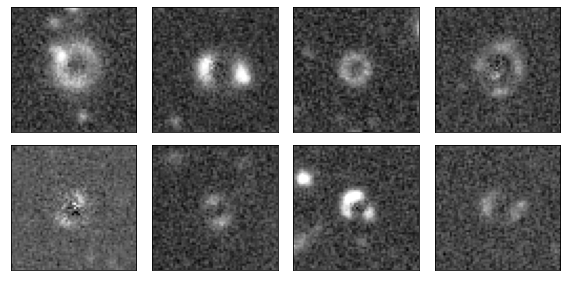

In [157]:
from plot_image_collage import plot_collage
from load_h5_file import load_h5_file
#plot_collage('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/training/1',2,5)
#RSP_images = load_h5_file('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/test/1')
#RSP_test_files = glob.glob('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/test/*npy')
#RSP_test_images = np.array([np.load(elem) for elem in RSP_test_files[0:100]])
def plot_collage_from_array(npy_array,N_cols=2,N_rows=2,vmin=None,vmax=None):
    fig,ax = pl.subplots(N_rows,N_cols,figsize=(2*N_cols,2*N_rows))
    for n_im in range(int(N_cols*N_rows)):
        x = n_im%N_rows
        y = np.floor(n_im/N_rows).astype('int')
        try: ax[x,y].imshow(npy_array[n_im],vmin=vmin,vmax=vmax,cmap='Greys_r')
        except: pass
        ax[x,y].set_xticks([]);ax[x,y].set_yticks([])
    pl.tight_layout()
    pl.show()

indx = np.array([10,16,17,21,33,45,46,56])
#plot_collage_from_array(RSP_test_images,5,2)
#Cherry picking the most obvious lenses to use here - still need to fix RSP vs LensPop detectability.
plot_collage_from_array(RSP_test_images[indx],4,2,None,2) 

In [50]:
def make_FP_databases(FP_network_predictions_dict,key):
    FP_network_truth_db = pd.DataFrame(FP_network_predictions_dict[key][0],columns=learning_params)
    FP_network_pred_mu_db = pd.DataFrame(FP_network_predictions_dict[key][1],columns=learning_params)
    FP_network_std_db = pd.DataFrame(FP_network_predictions_dict[key][2],columns=learning_params)
    return FP_network_truth_db, FP_network_pred_mu_db, FP_network_std_db

FP_truth_db,FP_pred_db,FP_std_db = make_FP_databases(FP_network_predictions_dict,key=0)

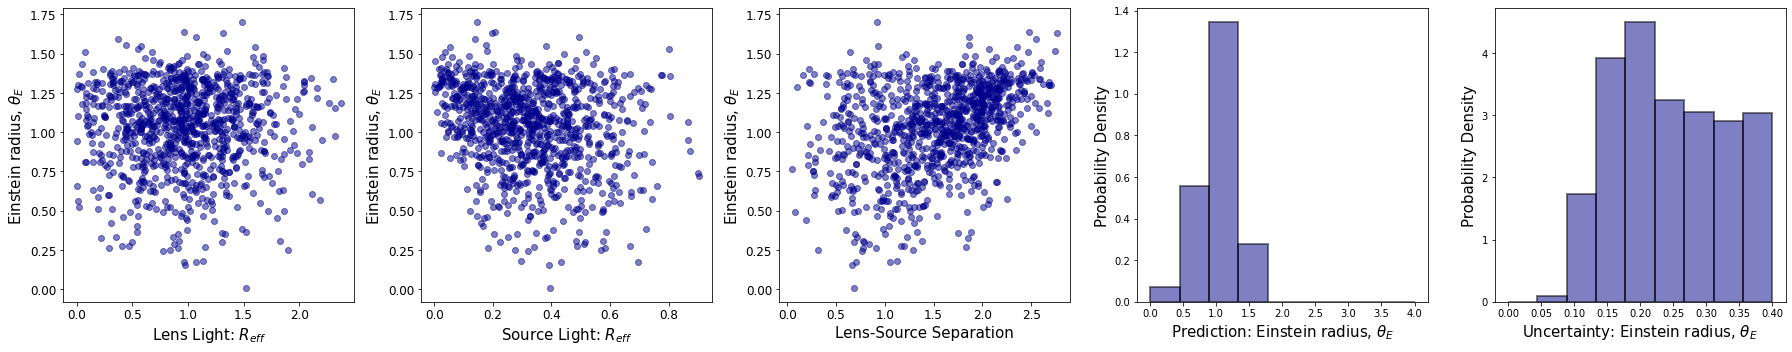

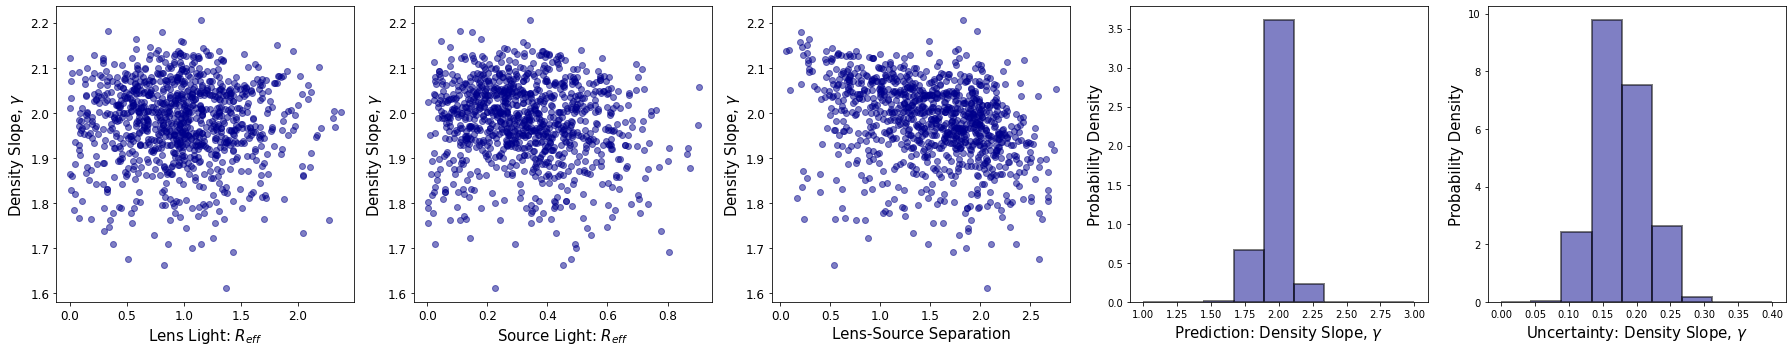

In [100]:
params_to_plot = ['main_deflector_parameters_theta_E',
                 'main_deflector_parameters_gamma']
independent_variables = ['lens_light_parameters_R_sersic',
                         'source_parameters_R_sersic',
                         'lens-source_separation']
N_cols = len(independent_variables) +2
N_rows = len(params_to_plot)
plot_dict = {'color':'darkblue','alpha':0.5}
hist_dict = {'density':True,'edgecolor':'k','linewidth':2}
for p_i in params_to_plot:
    fig,ax = pl.subplots(1,N_cols,figsize=(5 *N_cols,5))
    for xx,indep_var in enumerate(independent_variables):
        ax[xx].scatter(FP_metadata_val[indep_var],FP_pred_db[p_i],**plot_dict)
        ax[xx].set_xlabel(title_dict[indep_var],fontsize=15)
        ax[xx].set_ylabel(title_dict[p_i],fontsize=15)
        ax[xx].tick_params(labelsize=12)
    ax[xx+1].hist(FP_pred_db[p_i],**plot_dict,bins=np.linspace(truth_range_dict[p_i][0],
                                                               truth_range_dict[p_i][1],10),
                  **hist_dict)
    ax[xx+1].set_xlabel(f'Prediction: {title_dict[p_i]}',fontsize=15)
    ax[xx+1].set_ylabel('Probability Density',fontsize=15)
    ax[xx+2].hist(FP_std_db[p_i],**plot_dict,bins=np.linspace(0,Uncertainty_range_dict[p_i],10),
                  **hist_dict)
    ax[xx+2].set_xlabel(f'Uncertainty: {title_dict[p_i]}',fontsize=15)
    ax[xx+2].set_ylabel('Probability Density',fontsize=15)
    pl.tight_layout()
    pl.show()

In [ ]:
#Plot to see what proportion of the network posteriors (i.e the network outputs) lie outside the training prior, i.e to see how many the network believes it is 
#extrapolating for.

X_plot_dict = {'main_deflector_parameters_theta_E':np.linspace(0,3,100),
'main_deflector_parameters_gamma1':np.linspace(-0.5,0.5,100),
'main_deflector_parameters_gamma2':np.linspace(-0.5,0.5,100),
'main_deflector_parameters_gamma':np.linspace(1,3,100),
'main_deflector_parameters_e1':np.linspace(-0.5,0.5,100),
'main_deflector_parameters_e2':np.linspace(-0.5,0.5,100),
'main_deflector_parameters_center_x':np.linspace(-0.5,0.5,100),
'main_deflector_parameters_center_y':np.linspace(-0.5,0.5,100),
}

N_cols=4
fig,ax = pl.subplots(2,N_cols,figsize=(20,10))
fig2,ax2 = pl.subplots(1,figsize=(8,5))
for n_i,p_i in enumerate(prior_db['parameter']):
    x = n_i%N_cols
    y = np.floor(n_i/N_cols).astype('int')
    below_prior = (network_pred_mu_db[p_i].to_numpy()<(prior_db_indx.loc[p_i,'mean']-prior_db_indx.loc[p_i,'std']))
    above_prior = (network_pred_mu_db[p_i].to_numpy()>(prior_db_indx.loc[p_i,'mean']+prior_db_indx.loc[p_i,'std']))
    outside_prior = (below_prior|above_prior) #i.e. above or below prior
    ax[y,x].plot(X_plot_dict[p_i],norm.pdf(np.array([X_plot_dict[p_i]]*sum(1-outside_prior)).T,
                                                loc=network_pred_mu_db[p_i].to_numpy()[~outside_prior],
                                                scale=network_std_db[p_i].to_numpy()[~outside_prior]),c='k',alpha=0.1)
    if sum(below_prior)>0: ax[y,x].plot(X_plot_dict[p_i],norm.pdf(np.array([X_plot_dict[p_i]]*sum(below_prior)).T,
                                                loc=network_pred_mu_db[p_i].to_numpy()[below_prior],
                                                scale=network_std_db[p_i].to_numpy()[below_prior]),c='blue',alpha=0.1)
    if sum(above_prior)>0: ax[y,x].plot(X_plot_dict[p_i],norm.pdf(np.array([X_plot_dict[p_i]]*sum(above_prior)).T,
                                                loc=network_pred_mu_db[p_i].to_numpy()[above_prior],
                                                scale=network_std_db[p_i].to_numpy()[above_prior]),c='red',alpha=0.1)
    #Multiplying the prior by 5 so it can be seen:
    ax[y,x].plot(X_plot_dict[p_i],5*norm.pdf(X_plot_dict[p_i],prior_db_indx.loc[p_i,'mean'],
                                    prior_db_indx.loc[p_i,'std']),c='blue')
    ax[y,x].legend(handles=[
    mpatches.Patch(color='k', label='Paltas Posterior'),
    mpatches.Patch(color='red', label='Paltas Posterior '+\
                   f'({int(np.round(100*sum(below_prior)/len(below_prior)))}% below, '+\
                   f'{int(np.round(100*sum(above_prior)/len(above_prior)))}% above '+\
                   f'$1\sigma$ prior)'),
    mpatches.Patch(color='blue', label='Training Prior')],fontsize=8)
    ax[y,x].set_xlabel(p_i)
    ax2.scatter(np.median(network_std_db[p_i].to_numpy()),8-n_i,label=p_i)
    ax2.scatter(prior_db_indx.loc[p_i,'std'],8-n_i,marker='x',label='_nolegend_',c='red')

ax2.set_xlim(left=0)
ax2.set_title('$\sigma_{learnt}$ vs $\sigma_{prior}$',fontsize=18)
ax2.legend()
pl.show()

In [25]:
train_mean = np.array(pd.read_csv(glob.glob(f'{training_directory}/**/norm*',recursive=True)[0])['mean']) 
train_scatter = np.array(pd.read_csv(glob.glob(f'{training_directory}/**/norm*',recursive=True)[0])['std']) 

#Since we are using a diagonal covariance matrix, the precision matrix is the diagonal matrix of
#the (elementwise) values of 1/std^2. In general however it is inv(cov_matrix).

def make_val_databases(network_predictions_dict,key):
    val_or_test_HI = 'val'
    try: del test_data_db,test_data_db_sum
    except: pass
    final_epoch = key#max(list(network_predictions_dict.keys()))
    network_means = network_predictions_dict[final_epoch][1][:,:].astype('float64')              
    network_prec = network_predictions_dict[final_epoch][3][:,:,:].astype('float64')
    metadata_val = pd.read_csv(training_directory+'/validation/1/metadata.csv')

    final_epoch_n = key#np.max(list(network_predictions_dict.keys()))
    network_truth_db = pd.DataFrame(network_predictions_dict[final_epoch_n][0],columns=learning_params)
    network_pred_mu_db = pd.DataFrame(network_predictions_dict[final_epoch_n][1],columns=learning_params)
    network_std_db = pd.DataFrame(network_predictions_dict[final_epoch_n][2],columns=learning_params)

    bright_source_indx = np.where(metadata_val['source_parameters_mag_app']<25)[0]
    #Assert that the true parameters from the metadata are equal to those I'm getting from gen_network_predictions, to make sure there hasn't been any reshuffling
    #and to make sure I'm comparing the properties of the same objects. The 'round' is to remove the problem of some being saved as float32 and others as float64 files.
    db_a = np.round(network_truth_db[learning_params].astype('float32'),3)
    db_b = np.round(metadata_val[learning_params].astype('float32'),3)
    assert (db_a==db_b).all().all()
    return metadata_val,network_truth_db,network_pred_mu_db,network_std_db,bright_source_indx

def make_test_databases(network_predictions_test_dict,key):
    val_or_test_HI='test'
    try: del bright_source_indx
    except: pass
    final_epoch = max(list(network_predictions_test_dict.keys()))
    network_means = network_predictions_test_dict[final_epoch][1][:,:].astype('float64')              
    network_prec = network_predictions_test_dict[final_epoch][3][:,:,:].astype('float64')
    metadata_val = pd.DataFrame(network_predictions_test_dict[0][0],columns=learning_params)
    
    final_epoch_n = np.max(list(network_predictions_test_dict.keys()))
    network_truth_db = pd.DataFrame(network_predictions_test_dict[final_epoch_n][0],columns=learning_params)
    network_pred_mu_db = pd.DataFrame(network_predictions_test_dict[final_epoch_n][1],columns=learning_params)
    network_std_db = pd.DataFrame(network_predictions_test_dict[final_epoch_n][2],columns=learning_params)

    test_data_db = metadata_val.copy()
    test_data_db_sum = test_data_db.describe()
    #Assert that the true parameters from the metadata are equal to those I'm getting from gen_network_predictions, to make sure there hasn't been any reshuffling
    #and to make sure I'm comparing the properties of the same objects. The 'round' is to remove the problem of some being saved as float32 and others as float64 files.
    db_a = network_truth_db[learning_params].astype('float32')
    db_b = metadata_val[learning_params].astype('float32')
    assert (db_a==db_b).all().all()
    return metadata_val,network_truth_db,network_pred_mu_db,network_std_db

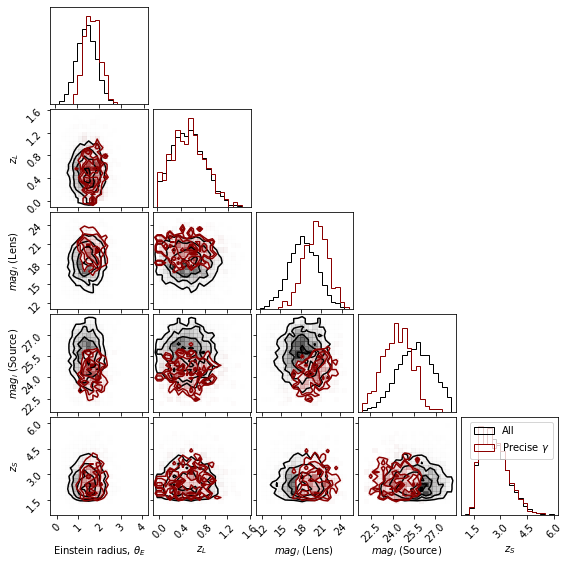

In [302]:
meta_columns_to_plot = [
                        'main_deflector_parameters_theta_E','main_deflector_parameters_z_lens',
                        'lens_light_parameters_mag_app',
                        'source_parameters_mag_app','source_parameters_z_source']
corner_range_dict = {
 'main_deflector_parameters_theta_E':(0,4),
    'main_deflector_parameters_z_lens':(0,1.5),
    'lens_light_parameters_mag_app':(12,25),
    'source_parameters_mag_app':(22,28),
    'source_parameters_z_source':(1,6)
}
fig = pl.figure(figsize=(8,8))
corner_dict = {'plot_datapoints':False,'fig':fig,
              'range':[corner_range_dict[l] for l in meta_columns_to_plot],'bins':20}
corner.corner(metadata_val[meta_columns_to_plot],**corner_dict,
              hist_kwargs={'density':True,'edgecolor':'k'})
corner.corner(metadata_val.loc[points_to_highlight][meta_columns_to_plot],**corner_dict,
              labels=[title_dict[l] for l in meta_columns_to_plot],color='darkred',
              hist_kwargs={'density':True,'edgecolor':'darkred'})
pl.legend(['All','Precise $\gamma$'])
pl.show()

In [27]:
def plot_histograms(ax,Truth,Pred,Uncertainty,image_property,color='darkblue'):
    t_range = truth_range_dict[image_property]
    e_range = Error_range_dict[image_property]
    u_range = Uncertainty_range_dict[image_property]
    hist_dict = {'density':True,'fill':'False','edgecolor':'k','alpha':0.5}
    ax[0].hist(Truth,bins=np.linspace(t_range[0],t_range[1],20),**hist_dict,label='Truth',color=color)
    ax[0].hist(Pred,bins=np.linspace(t_range[0],t_range[1],20),**hist_dict,label='Pred',color='darkgreen')
    ax[0].legend(fontsize=12)
    ax[1].hist(Uncertainty,bins=np.linspace(0,u_range,20),**hist_dict,color=color)
    ax[2].hist(Truth-Pred,bins=np.linspace(e_range[0],e_range[1],20),**hist_dict,color=color)
    ax[0].set_xlabel(title_dict[image_property],fontsize=15)
    ax[1].set_xlabel('Network Uncertainty',fontsize=15)
    ax[2].set_xlabel('Truth-Pred',fontsize=15)
    ax[2].set_ylim(0,Error_prob_density_dict[image_property])
    ax[1].set_ylim(0,Uncertainty_prob_density_dict[image_property])
    for i in range(3):
        ax[i].tick_params(labelsize=12)
        ax[i].set_ylabel('Probability Density',fontsize=15)
    pl.tight_layout()

def plot_scatter(ax,Truth,Pred,Uncertainty,image_property,color='darkblue'):
    scatter_dict = {'alpha':0.1,'s':10}
    errorbar_dict = {'alpha':0.1,'color':color_dict[test_or_val],'markersize':10,'fmt':'.'}
    kde_dict = {'levels':levels,'alpha':0.5,'fill':True,'color':color_dict[test_or_val],'zorder':2}
    random_indx = np.random.choice(len(network_truth_db),replace=False,size=100)
    #
    ax[0].scatter(Truth,Error,**scatter_dict,c=color_dict[test_or_val])
    #ax[0].scatter(Truth[points_to_highlight],Error[points_to_highlight],**scatter_dict,c='darkred')
    ax[0].set_xlabel('Truth',fontsize=15)
    ax[0].set_ylabel('Pred-Truth',fontsize=15)
    #
    ax[1].scatter(Error,Uncertainty,**scatter_dict,color=color_dict[test_or_val])
    #ax[1].scatter(Error[points_to_highlight],Uncertainty[points_to_highlight],**scatter_dict,color='darkred')
    text_i = f'{np.round(100*np.sum(abs(Error)<Uncertainty)/len(Error),1)}%'
    ax[1].set_xlabel('Truth-Pred',fontsize=15)
    ax[1].set_ylabel('Network Uncertainty',fontsize=15)
    #
    ax[2].scatter(Truth,Pred,**scatter_dict,color=color_dict[test_or_val])
    #ax[2].scatter(Truth[points_to_highlight],Pred[points_to_highlight],**scatter_dict,color='darkred')
    ax[2].set_xlabel('Truth',fontsize=15)
    ax[2].set_ylabel('Pred',fontsize=15)
    #Setting limits:
    ax[0].set_xlim(truth_range_dict[image_property])
    ax[0].set_ylim(Error_range_dict[image_property])
    ax[1].set_xlim(Error_range_dict[image_property])  
    ax[1].set_ylim(0,Uncertainty_range_dict[image_property])
    ax[1].text(0,0.9*ax[1].get_ylim()[1],ha='center',fontsize=15,color=color_dict[test_or_val],s=text_i)
    plot_error_lines(ax[1])
    ax[2].set_xlim(truth_range_dict[image_property])
    ax[2].set_ylim(truth_range_dict[image_property])
    ax3_ylim = ax[2].get_ylim();ax3_xlim = ax[2].get_xlim()
    ax3_min = np.min([ax3_xlim[0],ax3_ylim[1]])
    ax3_max = np.max([ax3_xlim[0],ax3_ylim[1]])
    ax[2].plot([ax3_min,ax3_max],[ax3_min,ax3_max],'--',c='k')
    #kdeplot(Truth,Error,ax=ax[0],**kde_dict)
    #kdeplot(Error,Uncertainty,ax=ax[2],**kde_dict)
    for i in range(3):
        ax[i].tick_params(labelsize=12)


/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/


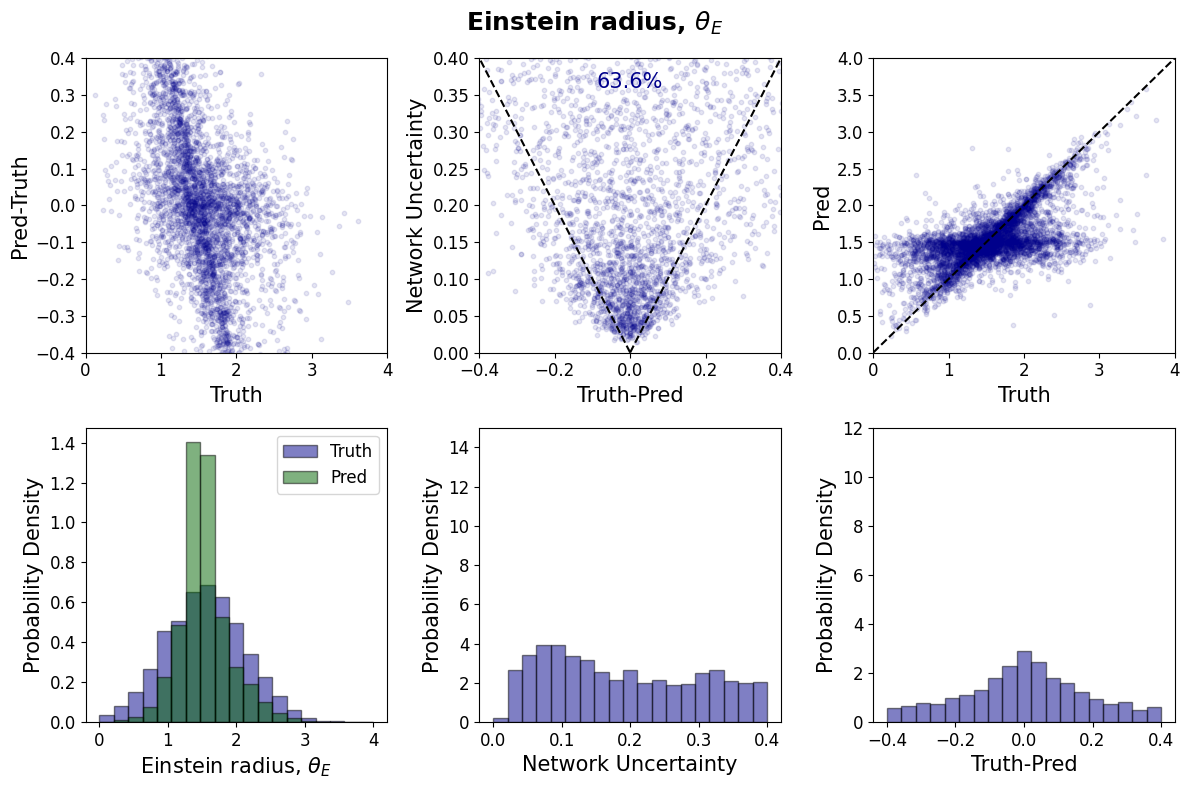

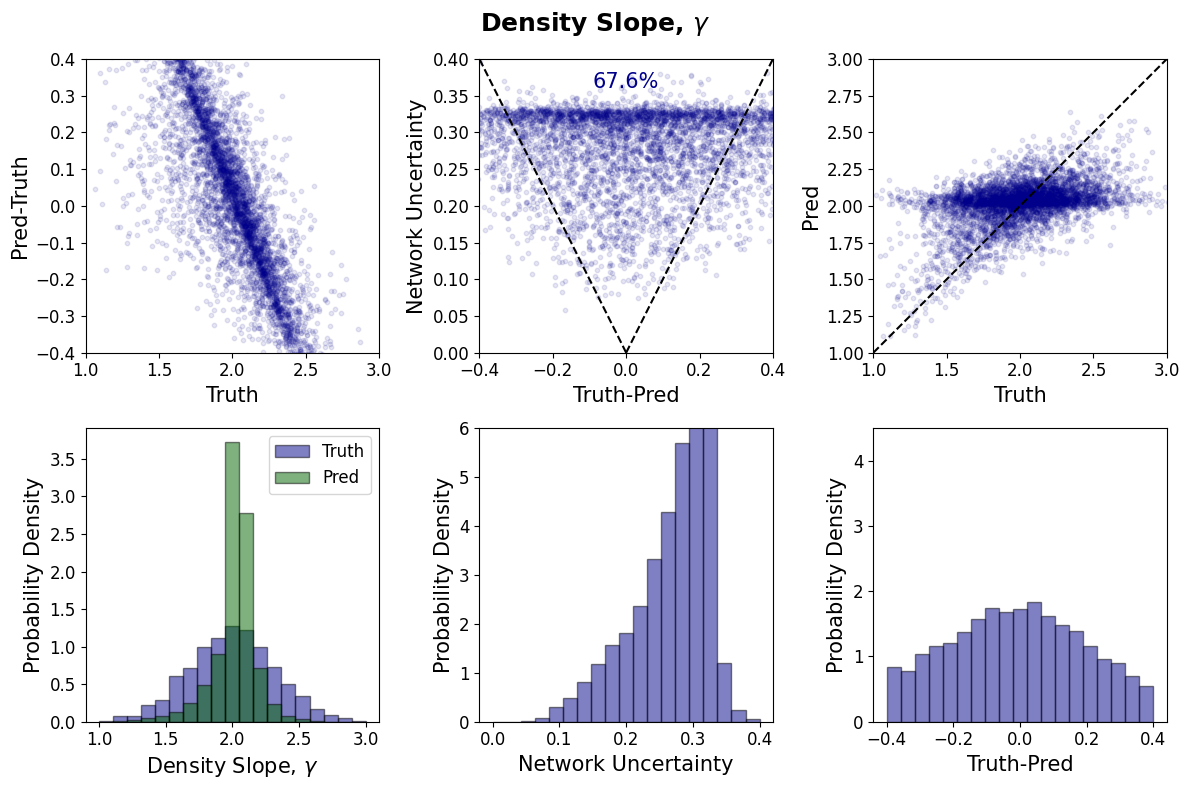

In [46]:
from seaborn import kdeplot
def plot_error_lines(ax):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    max_val = np.max([xlim[1],ylim[1]])
    error_line_dict = {'color':'k','linestyle':'--'}
    ax.plot([0,max_val],[0,max_val],**error_line_dict)
    ax.plot([0,-max_val],[0,max_val],**error_line_dict)

property_list = [
     'main_deflector_parameters_theta_E',
    'main_deflector_parameters_gamma',
#    'main_deflector_parameters_gamma1',
#    'main_deflector_parameters_gamma2',
#    'main_deflector_parameters_center_x',
#    'main_deflector_parameters_center_y',
#    'main_deflector_parameters_e1','main_deflector_parameters_e2'
]


Error_range_dict = {'main_deflector_parameters_theta_E':(-0.4,0.4),
                    'main_deflector_parameters_gamma':(-0.4,0.4),
                    'main_deflector_parameters_gamma1':(-0.2,0.2),
                    'main_deflector_parameters_gamma2':(-0.2,0.2),
                    'main_deflector_parameters_e1':(-0.4,0.4),
                    'main_deflector_parameters_e2':(-0.4,0.4),
                    'main_deflector_parameters_center_x':(-0.2,0.2),
                    'main_deflector_parameters_center_y':(-0.2,0.2),
                   }
Uncertainty_range_dict = {'main_deflector_parameters_theta_E':0.4,
                    'main_deflector_parameters_gamma':0.4,
                    'main_deflector_parameters_gamma1':0.1,
                    'main_deflector_parameters_gamma2':0.1,
                    'main_deflector_parameters_e1':0.4,
                    'main_deflector_parameters_e2':0.4,
                    'main_deflector_parameters_center_x':0.1,
                    'main_deflector_parameters_center_y':0.1,
                   }

truth_range_dict = {'main_deflector_parameters_theta_E':(0,4),
                    'main_deflector_parameters_gamma':(1,3),
                    'main_deflector_parameters_gamma1':(-0.2,0.2),
                    'main_deflector_parameters_gamma2':(-0.2,0.2),
                    'main_deflector_parameters_e1':(-0.6,0.6),
                    'main_deflector_parameters_e2':(-0.6,0.6),
                    'main_deflector_parameters_center_x':(-0.2,0.2),
                    'main_deflector_parameters_center_y':(-0.2,0.2),
                   }

Error_prob_density_dict = {'main_deflector_parameters_theta_E':12,
                    'main_deflector_parameters_gamma':4.5,
                    'main_deflector_parameters_gamma1':0.1,
                    'main_deflector_parameters_gamma2':0.1,
                    'main_deflector_parameters_e1':0.4,
                    'main_deflector_parameters_e2':0.4,
                    'main_deflector_parameters_center_x':0.1,
                    'main_deflector_parameters_center_y':0.1}

Uncertainty_prob_density_dict = {'main_deflector_parameters_theta_E':15,
                    'main_deflector_parameters_gamma':6,
                    'main_deflector_parameters_gamma1':0.1,
                    'main_deflector_parameters_gamma2':0.1,
                    'main_deflector_parameters_e1':0.4,
                    'main_deflector_parameters_e2':0.4,
                    'main_deflector_parameters_center_x':0.1,
                    'main_deflector_parameters_center_y':0.1}

levels = 1-np.array([1 - np.exp(-(2**2)/2),#% Contained within 2,1 sigma (have to do 1- as the levels does fraction *below* contour)
                     1 - np.exp(-(1**2)/2),# => See https://corner.readthedocs.io/en/latest/pages/sigmas/ for why this equation is used.
                     0])   
print(training_directory)

test_or_val = 'val'
color_dict = {'test':'darkred','val':'darkblue'}
keys_list = list(network_predictions_dict.keys())
keys_list.sort()
for n_k,key_i in enumerate(keys_list):
    assert test_or_val in ['test','val']
    if test_or_val=='val':
        metadata_val,network_truth_db,network_pred_mu_db,network_std_db,bright_source_indx =\
                make_val_databases(network_predictions_dict,key_i)
    if test_or_val=='test':
        metadata_val,network_truth_db,network_pred_mu_db,network_std_db =\
                make_test_databases(network_predictions_test_dict,key_i)
    # gamma_error = np.array(abs(network_pred_mu_db['main_deflector_parameters_gamma']-\
    #                           network_truth_db['main_deflector_parameters_gamma']))
    # gamma_uncertainty = np.array(network_std_db['main_deflector_parameters_gamma'])
    # points_to_highlight = []#np.where((gamma_error<0.05)&(gamma_uncertainty<0.05))[0]
    for p_i,image_property in enumerate(property_list):
        fig,ax = pl.subplots(2,3,figsize=(12,8))
        Error = network_pred_mu_db[image_property]-network_truth_db[image_property]
        Uncertainty = network_std_db[image_property]
        Truth = metadata_val[image_property]
        Pred = network_pred_mu_db[image_property]
        plot_scatter(ax[0,:],Truth,Pred,Uncertainty,image_property,color_dict[test_or_val])    
        plot_histograms(ax[1,:],Truth,Pred,Uncertainty,image_property,color_dict[test_or_val])
        pl.suptitle(title_dict[image_property],fontweight='bold',fontsize=18)
        pl.tight_layout()
        #for fmt in ['.pdf','.png']:
        #    pl.savefig(f'/mnt/zfsusers/hollowayp/paltas/paltas_plots/{image_property}_{n_k}{fmt}',bbox_inches='tight')
        pl.show()



In [50]:
metadata_val.columns

Index(['Magnification', 'cosmology_parameters_cosmology_name',
       'detector_parameters_background_noise', 'detector_parameters_ccd_gain',
       'detector_parameters_exposure_time',
       'detector_parameters_magnitude_zero_point',
       'detector_parameters_pixel_scale', 'detector_parameters_read_noise',
       'detector_parameters_sky_brightness', 'lens_light_parameters_R_sersic',
       'lens_light_parameters_center_x', 'lens_light_parameters_center_y',
       'lens_light_parameters_e1', 'lens_light_parameters_e2',
       'lens_light_parameters_mag_app', 'lens_light_parameters_n_sersic',
       'lens_light_parameters_output_ab_zeropoint',
       'lens_light_parameters_z_source', 'main_deflector_parameters_M200',
       'main_deflector_parameters_center_x',
       'main_deflector_parameters_center_y', 'main_deflector_parameters_dec_0',
       'main_deflector_parameters_e1', 'main_deflector_parameters_e2',
       'main_deflector_parameters_gamma', 'main_deflector_parameters_gamm

In [55]:
title_dict

{'main_deflector_parameters_gamma': 'Density Slope, $\\gamma$',
 'main_deflector_parameters_theta_E': 'Einstein radius, $\\theta_E$',
 'main_deflector_parameters_e1': 'Lens Ellipticity, $e_1$',
 'main_deflector_parameters_e2': 'Lens Ellipticity, $e_2$',
 'main_deflector_parameters_gamma1': 'Lens Shear,$\\gamma_1$',
 'main_deflector_parameters_gamma2': 'Lens Shear,$\\gamma_2$',
 'main_deflector_parameters_center_x': 'Lens Center, x',
 'main_deflector_parameters_center_y': 'Lens Center, y',
 'lens_light_parameters_mag_app': '$mag_i$ (Lens)',
 'source_parameters_mag_app': '$mag_i$ (Source)',
 'main_deflector_parameters_z_lens': '$z_L$',
 'source_parameters_z_source': '$z_S$',
 'lens_light_parameters_R_sersic': 'Lens Light: $R_{eff}$',
 'source_parameters_R_sersic': 'Source Light: $R_{eff}$',
 'lens-source_separation': 'Lens-Source Separation'}

In [81]:
def make_color_array(array):
    vmin = np.min(array)
    vmax = np.max(array)
    return (array)#-vmin)/(vmax-vmin)

In [91]:
metadata_val.columns

Index(['Magnification', 'cosmology_parameters_cosmology_name',
       'detector_parameters_background_noise', 'detector_parameters_ccd_gain',
       'detector_parameters_exposure_time',
       'detector_parameters_magnitude_zero_point',
       'detector_parameters_pixel_scale', 'detector_parameters_read_noise',
       'detector_parameters_sky_brightness', 'lens_light_parameters_R_sersic',
       'lens_light_parameters_center_x', 'lens_light_parameters_center_y',
       'lens_light_parameters_e1', 'lens_light_parameters_e2',
       'lens_light_parameters_mag_app', 'lens_light_parameters_n_sersic',
       'lens_light_parameters_output_ab_zeropoint',
       'lens_light_parameters_z_source', 'main_deflector_parameters_M200',
       'main_deflector_parameters_center_x',
       'main_deflector_parameters_center_y', 'main_deflector_parameters_dec_0',
       'main_deflector_parameters_e1', 'main_deflector_parameters_e2',
       'main_deflector_parameters_gamma', 'main_deflector_parameters_gamm

This is loading/plotting the validation set


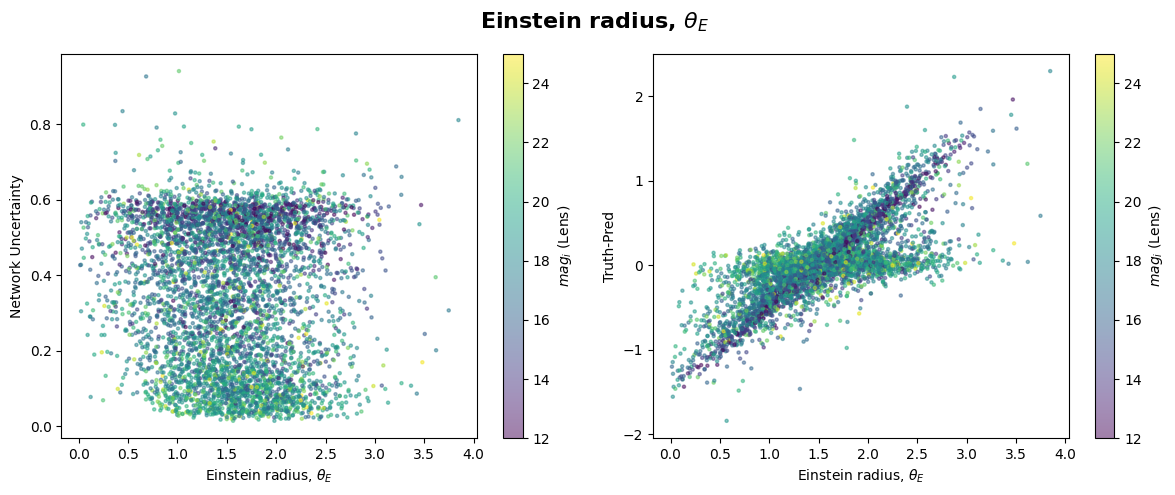

In [108]:
print('This is loading/plotting the validation set')
metadata_val,network_truth_db,network_pred_mu_db,network_std_db,bright_source_indx =\
                make_val_databases(network_predictions_dict,key_i)
fig,ax = pl.subplots(1,2,figsize=(12,5))

X_0 = 'main_deflector_parameters_theta_E'
Y_0 = 'main_deflector_parameters_theta_E'
C_0 = 'lens_light_parameters_mag_app'
scatter_dict = {'alpha':0.5,'s':5,'vmin':12,'vmax':25}#'vmin':22,'vmax':28}
c1 = ax[0].scatter(metadata_val[X_0],network_std_db[Y_0],c=make_color_array(metadata_val[C_0]),**scatter_dict)
ax[0].set_xlabel(title_dict[X_0])
ax[0].set_ylabel('Network Uncertainty')
c2 = ax[1].scatter(metadata_val[X_0],
        network_truth_db[Y_0]-network_pred_mu_db[Y_0],c=make_color_array(metadata_val[C_0]),**scatter_dict)
ax[1].set_xlabel(title_dict[X_0])
ax[1].set_ylabel('Truth-Pred')
pl.colorbar(c1,label=title_dict[C_0])
pl.colorbar(c2,label=title_dict[C_0])
pl.suptitle(title_dict[Y_0],fontsize=16,fontweight='bold')
pl.tight_layout()
pl.show()

(array([1.000e+01, 6.700e+01, 3.370e+02, 9.660e+02, 1.498e+03, 1.282e+03,
        6.400e+02, 1.740e+02, 2.500e+01, 1.000e+00]),
 array([18.50543859, 19.76021083, 21.01498308, 22.26975533, 23.52452757,
        24.77929982, 26.03407207, 27.28884431, 28.54361656, 29.79838881,
        31.05316105]),
 <BarContainer object of 10 artists>)

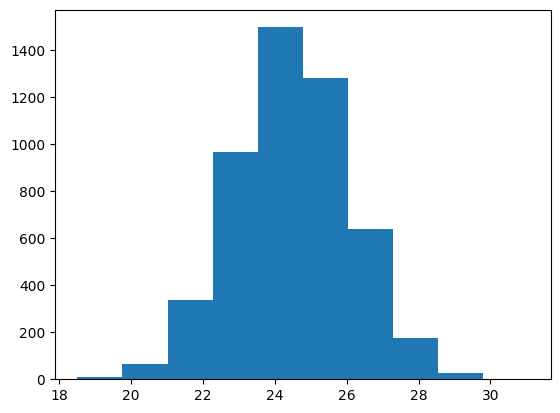

In [98]:
pl.hist(metadata_val[C_0])

## Plot Network Output Distributions
We now plot the distributions of the network predictions, and compare those to the ground-truth

In [ ]:
db_columns = [elem.replace('main_deflector_parameters_','') for elem in learning_params]
Error_db = {elem:pd.DataFrame(columns=db_columns) for elem in network_predictions_dict.keys()}

def RMS_error_func(pred,truth,db_columns):
    #Calculates RMS error
    RMS_error =np.sqrt(np.mean((pred-truth)**2,axis=0))
    print(f'{len(RMS_error)} dimensional output') 
    return {db_columns[i]:RMS_error[i] for i in range(len(db_columns))}

def MAE_func(pred,truth,db_columns):
    #Calculates mean absolute error
    MAE_error = np.mean(abs(pred-truth),axis=0) 
    print(f'{len(MAE_error)} dimensional output') 
    return {db_columns[i]:MAE_error[i] for i in range(len(db_columns))}

#RMS_error_func(network_predictions_dict[epoch_i][0],network_predictions_dict[epoch_i][1])

for epoch_i in network_predictions_dict.keys():
    Error_db[epoch_i] = pd.concat([Error_db[epoch_i],pd.DataFrame(data=MAE_func(network_predictions_dict[epoch_i][0],
                                                                                network_predictions_dict[epoch_i][1],
                                                                                db_columns),
                                                                index=np.array(['MAE']))])
    Error_db[epoch_i] = pd.concat([Error_db[epoch_i],pd.DataFrame(data=RMS_error_func(network_predictions_dict[epoch_i][0],
                                                                                      network_predictions_dict[epoch_i][1],
                                                                                      db_columns),
                                                                index=np.array(['RMS']))])

Error_db[epoch_i]

In [ ]:
import imageio
label_kwargs = {'fontsize': 20}
range_dict = {'main_deflector_parameters_theta_E':(0,3),
              'main_deflector_parameters_gamma':(1,3),
              'main_deflector_parameters_gamma1':(-0.5,0.5),
              'main_deflector_parameters_gamma2':(-0.5,0.5),
              'main_deflector_parameters_e1':(-0.5,0.5),
              'main_deflector_parameters_e2':(-0.5,0.5),
              'main_deflector_parameters_center_x':(-0.5,0.5),
              'main_deflector_parameters_center_y':(-0.5,0.5)}
bins_corner=20
gif_images = []
for epoch_i in tqdm(network_predictions_dict.keys()):
    fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
    corner_kwargs_dict = {'fig':fig,'bins':bins_corner,'range':[range_dict[elem] for elem in learning_params]}
    corner.corner(network_predictions_dict[epoch_i][0],color='k',**corner_kwargs_dict)
    corner.corner(network_predictions_dict[epoch_i][1],color='red',\
                labels=['$'+elem+'$' for elem in corner_param_print],\
                label_kwargs=label_kwargs,
                **corner_kwargs_dict)
    pl.legend(['Truth','Pred'])
    pl.tight_layout()
#To save as a gif:
    pl.suptitle(f'Epoch {epoch_i}',fontsize=25,fontweight='bold')
    try:
        pl.savefig(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
    except:
        os.mkdir(f'{model_directory}/corner_plots/')
        pl.savefig(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
#    pl.show()
    pl.close()
    corner_i = imageio.imread(f'{model_directory}/corner_plots/corner_plot_evolution_{epoch_i}.png')
    gif_images.append(corner_i)

imageio.mimsave(f'{model_directory}/corner_plots/corner_plot_evolution.gif', gif_images,duration=2)


In [2]:
import sys
sys.path.append('/mnt/zfsusers/hollowayp/paltas')
from paltas.Sampling.distributions import RedshiftsTruncNorm

/mnt/zfsusers/hollowayp/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [6]:
from scipy.stats import norm, truncnorm, uniform

zL_mu = 0.5
zL_sigma = 0.25
zS_mu = 1
zS_sigma = 0.5

zL_trunc,zS_trunc = [],[]
redshift_class = RedshiftsTruncNorm(z_lens_min=0,z_lens_mean=zL_mu,z_lens_std=zL_sigma,
                                        z_source_min=0,z_source_mean=zS_mu,z_source_std=zS_sigma)
for i in tqdm(range(1000)):
    zL_i,zS_i = redshift_class.__call__()
    zL_trunc.append(zL_i)
    zS_trunc.append(zS_i)

100%|██████████| 1000/1000 [00:01<00:00, 811.76it/s]


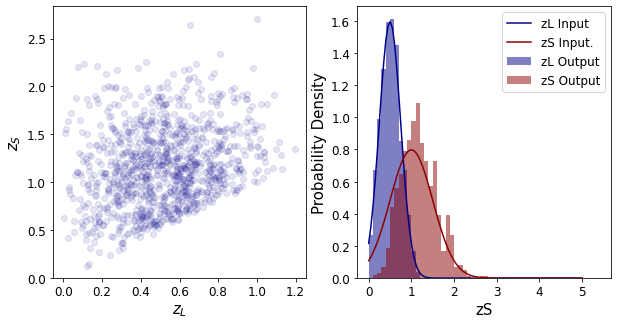

In [7]:
X_plot = np.linspace(0,5,100)

fig,ax = pl.subplots(1,2,figsize=(10,5))
ax[0].scatter(zL_trunc,zS_trunc,alpha=0.1,color='darkblue')
ax[0].set_xlabel('$z_L$',fontsize=15)
ax[0].set_ylabel('$z_S$',fontsize=15)
ax[1].hist(zL_trunc,bins=np.arange(0,5.5,0.1),density=True,label='zL Output',color='darkblue',alpha=0.5)
ax[1].hist(zS_trunc,bins=np.arange(0,5.5,0.1),density=True,label='zS Output',color='darkred',alpha=0.5)
ax[1].plot(X_plot,norm(zL_mu,zL_sigma).pdf(X_plot),label='zL Input',color='darkblue')
ax[1].plot(X_plot,norm(zS_mu,zS_sigma).pdf(X_plot),label='zS Input.',color='darkred')
ax[1].set_ylabel('Probability Density',fontsize=15)
ax[1].set_xlabel('zS',fontsize=15)
ax[1].legend(fontsize=12)
for i in range(2):
    ax[i].tick_params(labelsize=12)
pl.show()

## Plot Training vs Test Corner Plots

In [12]:
for line in open(glob.glob(f'{training_directory}training/*/config*')[0],'r'):
    if 'norm(' in line:
        print(line.split(':')[0],line.split('scale=')[1].replace('\n','').replace(').rvs,',''))

'z_lens' 0.303
'gamma' 0.264
'theta_E' 0.4406
'e1' 0.1708
'e2' 0.1709
'center_x' 0.12
'center_y' 0.12
'gamma1' 0.078
'gamma2' 0.078
'z_source' 0.303
'mag_app' 2.1232
'R_sersic' 0.6025
'e1' 0.1708
'e2' 0.1709
'center_x' 0.12
'center_y' 0.12
'z_source' 1.038
'mag_app' 1.3289
'R_sersic' 0.2373
'e1' 0.2302
'e2' 0.2286
'center_x' 0.4621
'center_y' 0.6193
x_dist=norm(loc=0.0,scale=0.12).rvs, 
 0.12 
y_dist=norm(loc=0.0,scale=0.12).rvs),
 0.12).rvs),


Training:
main_deflector_parameters_theta_E    0.438869
main_deflector_parameters_gamma      0.264241
main_deflector_parameters_e1         0.173229
main_deflector_parameters_e2         0.171909
lens_light_parameters_z_source       0.270120
source_parameters_z_source           0.923467
lens_light_parameters_mag_app        2.125486
source_parameters_mag_app            1.325315
main_deflector_parameters_z_lens     0.275496
Name: std, dtype: float64
Test x 1.2
main_deflector_parameters_theta_E    0.440646
main_deflector_parameters_gamma      0.000000
main_deflector_parameters_e1         0.170784
main_deflector_parameters_e2         0.170919
lens_light_parameters_z_source       0.303032
source_parameters_z_source           1.038024
lens_light_parameters_mag_app        2.123351
source_parameters_mag_app            1.328952
main_deflector_parameters_z_lens     0.303032
Name: std, dtype: float64


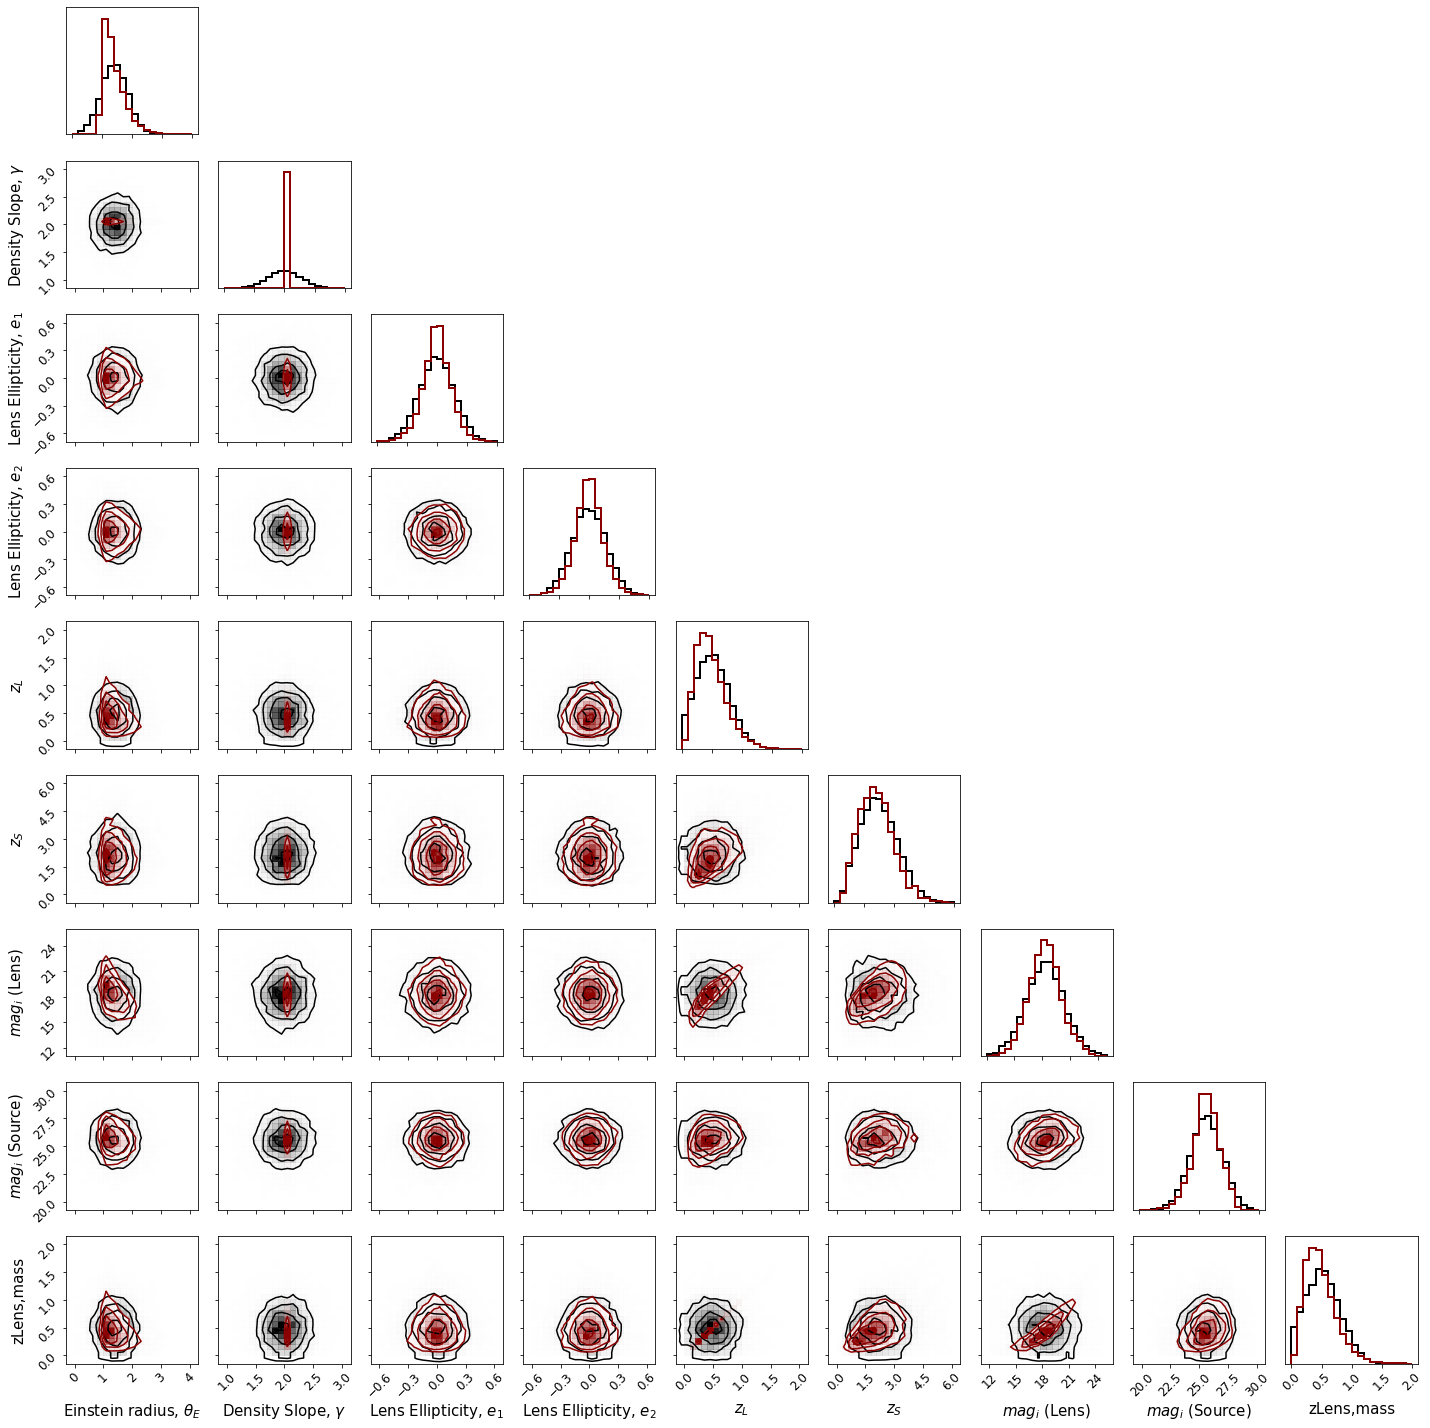

In [19]:
truth_range_dict['lens_light_parameters_z_source']=(0,2)
truth_range_dict['source_parameters_z_source']=(0,6)
truth_range_dict['lens_light_parameters_mag_app']=(12,25)
truth_range_dict['source_parameters_mag_app']=(20,30)
truth_range_dict['main_deflector_parameters_z_lens']=(0,2)
title_dict['lens_light_parameters_z_source']='$z_L$'
title_dict['main_deflector_parameters_z_lens']='zLens,mass'

def plot_training_test_corner_plot(training_metadata_csv_file,test_metadata_csv_file):
    training_dist = pd.read_csv(training_metadata_csv_file)
    test_dist = pd.read_csv(test_metadata_csv_file)
    params_to_plot = ['main_deflector_parameters_theta_E','main_deflector_parameters_gamma',
                     'main_deflector_parameters_e1','main_deflector_parameters_e2',
                     'lens_light_parameters_z_source','source_parameters_z_source',
                     'lens_light_parameters_mag_app','source_parameters_mag_app',
                     'main_deflector_parameters_z_lens']
    fig,ax = pl.subplots(len(params_to_plot),len(params_to_plot),figsize=(20,20))
    corner_dict = {'fig':fig,'range':[truth_range_dict[elem] for elem in params_to_plot],
                   'bins':20,
                   'labels':[title_dict[elem] for elem in params_to_plot],
                   'plot_datapoints':False}
    print('Training:')
    print(training_dist[params_to_plot].describe().loc['std'])
    print('Test x 1.2')
    print(1.2*test_dist[params_to_plot].describe().loc['std'])
    corner.corner(training_dist[params_to_plot],**corner_dict,
                  hist_kwargs={"density":True,'edgecolor':'k','linewidth':2},
                  color='k')
    corner.corner(test_dist[params_to_plot],**corner_dict,
                  hist_kwargs={"density":True,'edgecolor':'darkred','linewidth':2},
                  color='darkred')
    for ii in range(len(params_to_plot)):
        for jj in range(len(params_to_plot)):
            x_l = ax[ii,jj].get_xlabel()
            y_l = ax[ii,jj].get_ylabel()
            ax[ii,jj].set_xlabel(x_l,fontsize=15)
            ax[ii,jj].set_ylabel(y_l,fontsize=15)
            ax[ii,jj].tick_params(labelsize=12)
    pl.tight_layout()
    pl.show()

plot_training_test_corner_plot('/mnt/zfsusers/hollowayp/paltas/extraspace_files/metadata.csv',
                               glob.glob(f'{test_directory}/test/metadata.csv')[0])

## Load Model Outputs
The hyperparameters of the training set are loaded (to use as an interim prior in the hierarchical inference), along with the network predictions for the validation set

# Hierarchical Inference
The following performs hierarchical inference to retrieve the population hyperparameters of the validation set, assuming a diagonal covariance matrix.

6 2


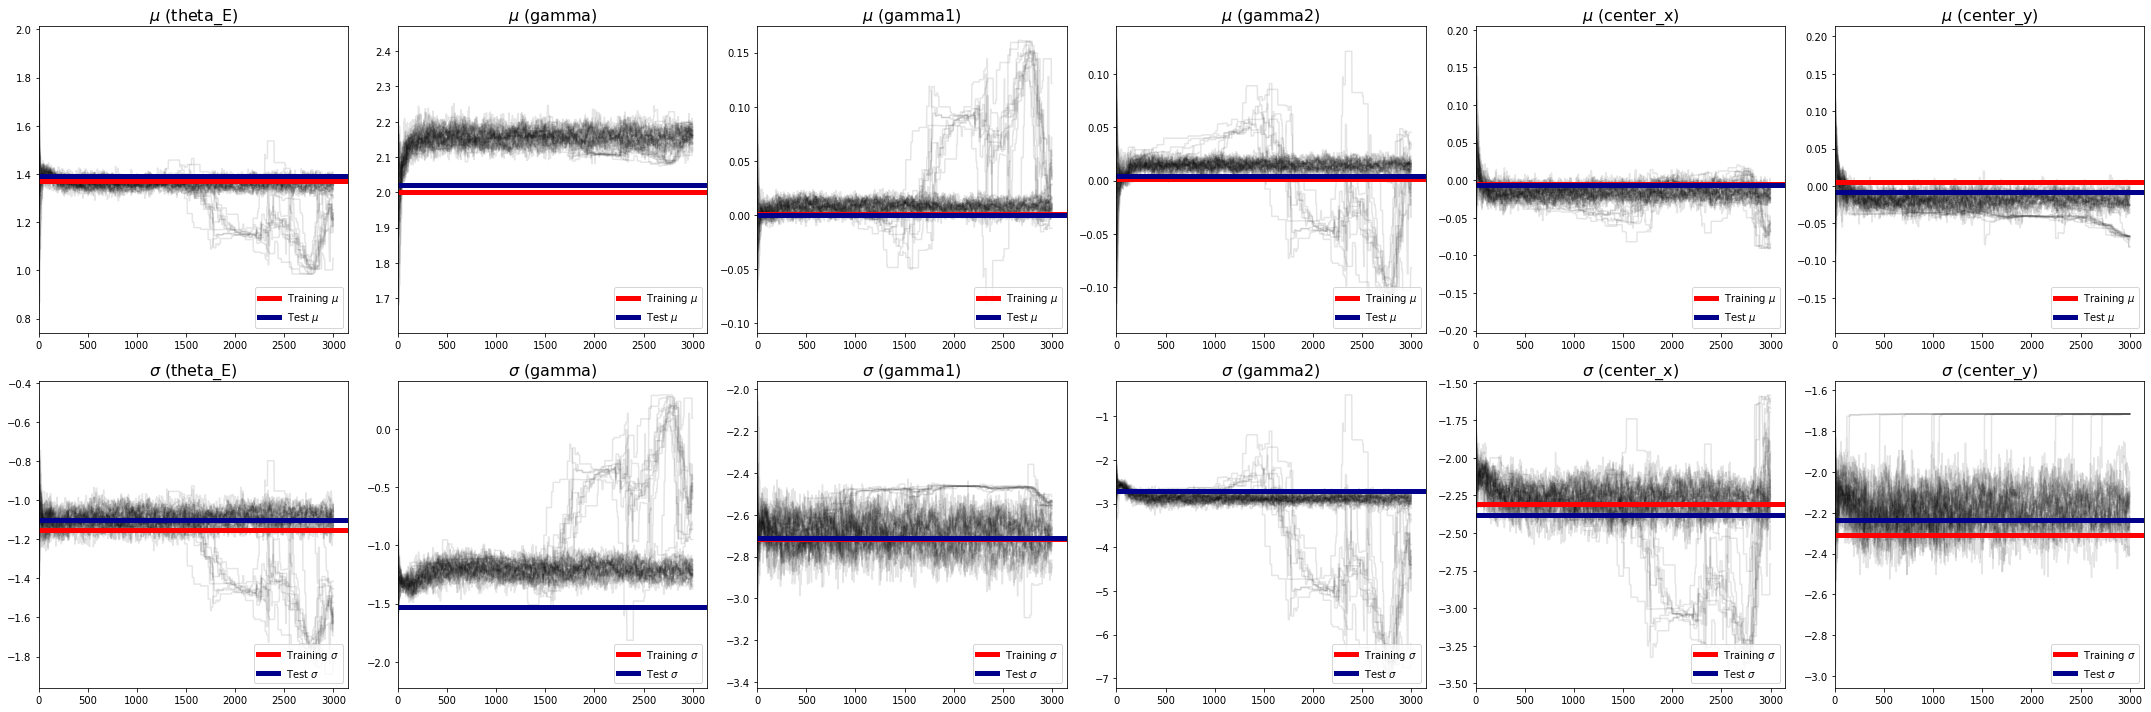

NOTE: The sigma are in natural logarithms, not in log10.


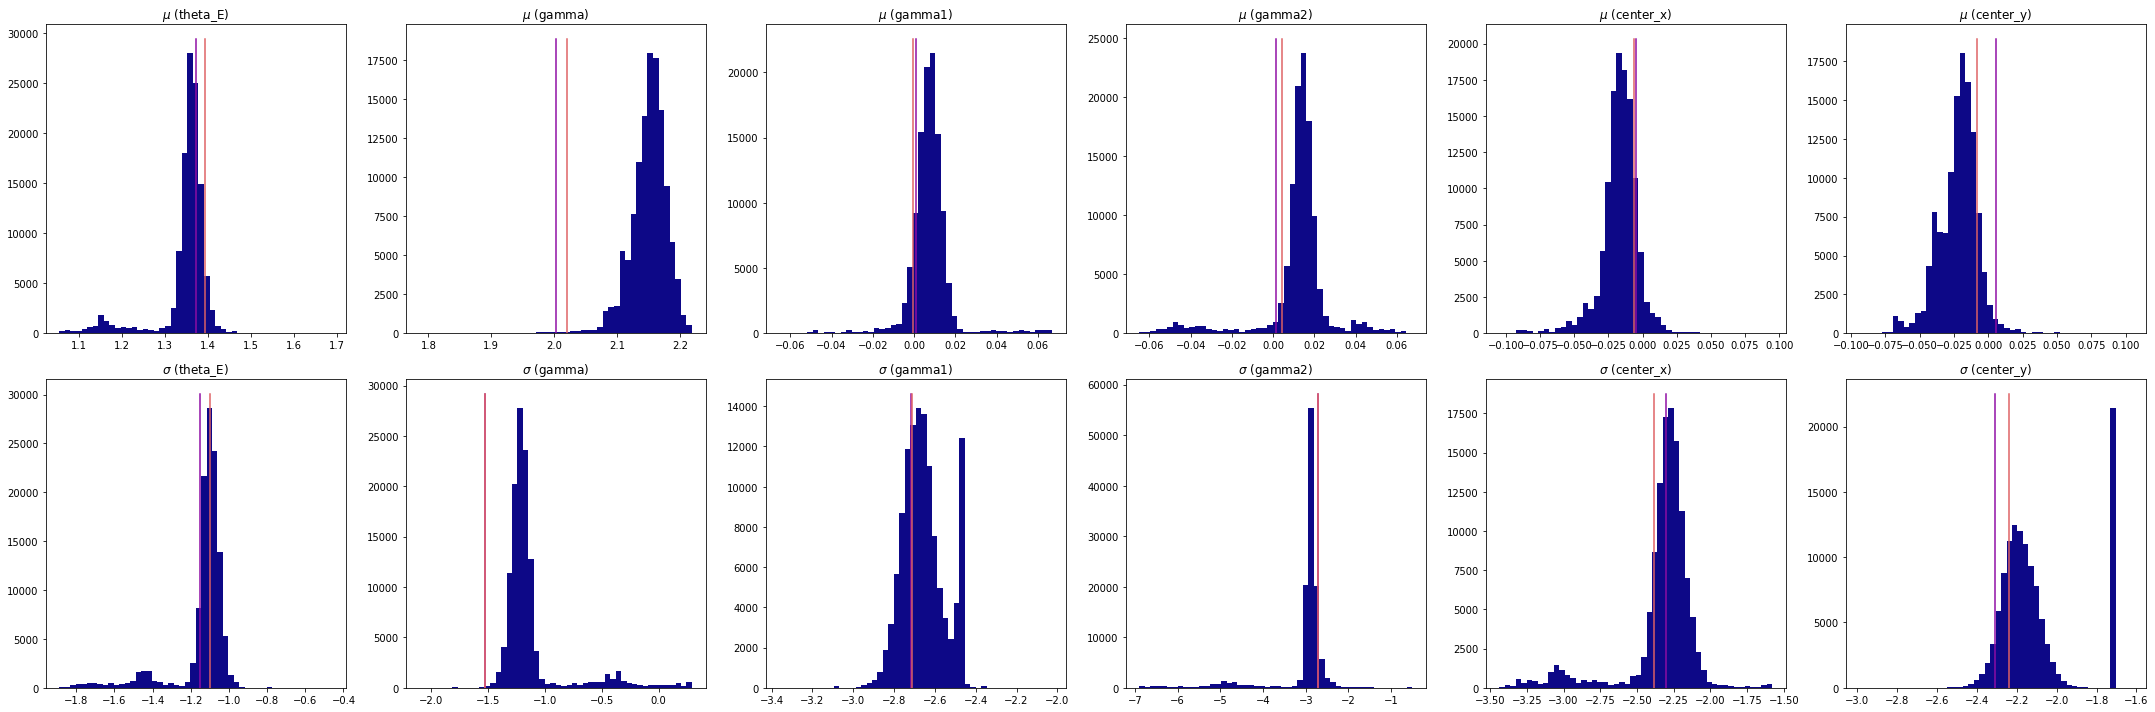

In [378]:
import warnings
def plot_sampler_properties(plot_evolution=False,plot_post_burnin=False,burnin=1000,burnout=None,
                           learning_params_for_HI=None):
    warnings.filterwarnings('ignore',category=DeprecationWarning)
    #[walker,evolution_number,property]
    N_cols = len(learning_params_for_HI) #Needs to stay as N_params, as one row is the mean, the other is the sigma (and the titles are defined as such.)
    N_rows = np.ceil(2*len(learning_params_for_HI)/N_cols).astype('int')
    print(N_cols,N_rows)
    if plot_evolution:
        fig,ax = pl.subplots(N_rows,N_cols,figsize=(5*N_cols,5*N_rows))
        for prop_i in range(2*len(learning_params_for_HI)):
            x = prop_i%N_cols
            y = np.floor(prop_i/N_cols).astype('int')
            param_i = learning_params_for_HI[prop_i%len(learning_params_for_HI)]
            for c_i in range(40):
                ax[y,x].plot(chain_orig[c_i,:,prop_i],alpha=0.1,c='k')
                ax[y,x].set_title('$\mu$ ('*(y==0)+'$\sigma$ ('*(y==1)+learning_params_for_HI[prop_i%N_cols].replace('main_deflector_parameters_','')+')',
                                fontsize=16)
                ax[y,x].set_xlim(burnin,burnout)
            if prop_i<len(learning_params_for_HI):
                    '''Am using 2*[] to duplicate the values in the list, rather than doubling the values
                    '''
                    ax[y,x].plot(ax[y,x].get_xlim(),
                                 2*[prior_db_indx.loc[param_i]['mean']],
                                 c='red',label='Training $\mu$',linewidth=5)
                    if val_or_test_HI=='test':
                        ax[y,x].plot(ax[y,x].get_xlim(),2*[test_data_db_sum.loc['mean',param_i]],
                                c='darkblue',label='Test $\mu$',linewidth=5)
            else:
                    ax[y,x].plot(ax[y,x].get_xlim(),2*[np.log(prior_db_indx.loc[param_i]['std'])],
                                c='red',label='Training $\sigma$',linewidth=5)
                    if val_or_test_HI=='test':
                        ax[y,x].plot(ax[y,x].get_xlim(),2*[np.log(test_data_db_sum.loc['std',param_i])],
                                c='darkblue',label='Test $\sigma$',linewidth=5)
            ax[y,x].legend(loc='lower right')
#            ax[y,x].set_ylim(-1,1)
        pl.tight_layout()
        pl.show()
    if plot_post_burnin:
        print("NOTE: The sigma are in natural logarithms, not in log10.")
        fig,ax = pl.subplots(N_rows,N_cols,figsize=(5*N_cols,5*N_rows))
        for prop_i in range(2*len(learning_params_for_HI)):
            prop_i_val = learning_params_for_HI[prop_i%len(learning_params_for_HI)]
            x = prop_i%N_cols
            y = np.floor(prop_i/N_cols).astype('int')
            if prop_i<len(learning_params_for_HI):
                bins=np.linspace(
                             prior_db_indx.loc[prop_i_val]['mean']-prior_db_indx.loc[prop_i_val]['std'],
                             prior_db_indx.loc[prop_i_val]['mean']+prior_db_indx.loc[prop_i_val]['std'],
                             50)
                ax[y,x].hist(chain_orig[:,burnin:burnout,prop_i].flatten(),bins=bins)
                ax_ylim = ax[y,x].get_ylim()
                ax[y,x].plot([prior_db_indx.loc[prop_i_val]['mean']]*2,ax_ylim)
                if val_or_test_HI=='test':
                    ax[y,x].plot(2*[test_data_db_sum.loc['mean',prop_i_val]],ax_ylim)
            else:
                bins=50
                ax[y,x].hist(chain_orig[:,burnin:burnout,prop_i].flatten(),bins=bins)
                ax_ylim = ax[y,x].get_ylim()
                ax[y,x].plot(2*[np.log(prior_db_indx.loc[prop_i_val]['std'])],ax_ylim)
                if val_or_test_HI=='test':
                    ax[y,x].plot(2*[np.log(test_data_db_sum.loc['std',prop_i_val])],ax_ylim)
            ax[y,x].set_title('$\mu$ ('*(y==0)+'$\sigma$ ('*(y==1)+learning_params_for_HI[prop_i%N_cols].replace('main_deflector_parameters_','')+')')
        pl.tight_layout()
        pl.show()

plot_sampler_properties(plot_evolution=True,
                        plot_post_burnin=True,
                        burnin=0,
                        burnout=None,
                        learning_params_for_HI = ['main_deflector_parameters_theta_E',
                                                  'main_deflector_parameters_gamma',
                                                  'main_deflector_parameters_gamma1',
                                                  'main_deflector_parameters_gamma2',
                                                  'main_deflector_parameters_center_x',
                                                  'main_deflector_parameters_center_y',
#                                                  'main_deflector_parameters_e1',
#                                                  'main_deflector_parameters_e2'
                                                   ])

In [357]:
np.shape(chain_orig)

(40, 3000, 12)

In [ ]:
from importlib import reload  # Python 3.4+
hierarchical_inference = reload(hierarchical_inference)

In [7]:
#Due to the current implementation of hierarchical_inference.ProbabilityClassAnalytical.log_post_omega, we assert
#that the covariance matrix must be diagonal for now.
assert loss_function=='diag'
burnin = int(1000)
n_samps = 20
#Saving arrays for hierarchical inference:
try:
    os.mkdir(f'{model_directory}/mcmc_files/')
except:
    pass
np.save(model_directory+'/mcmc_files/network_means.npy',network_means)
np.save(model_directory+'/mcmc_files/network_prec.npy',network_prec)
np.save(model_directory+'/mcmc_files/train_mean.npy',train_mean)
np.save(model_directory+'/mcmc_files/train_scatter.npy',train_scatter)
np.save(model_directory+'/mcmc_files/learning_params.npy',learning_params)
prior_db_indx.to_csv(model_directory+'/mcmc_files/prior_db_indx.csv')

#The MCMC hierarchical inference now takes place in ./run_mcmc.py:
print(f"addqueue -c '45min' -m  3 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_mcmc.py {model_directory} {n_samps} {num_params}")
!addqueue -c '45min' -m  3 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_mcmc.py $model_directory $n_samps $num_params
print('Settings in run_mcmc.py:'+\
        '\n1) The mu values must be within 5-sigma of the training prior. The mu and sigma values are HARDCODED and need to be UPDATED with each new training set.'+\
        '\n2) The sigma values must be between 0.001 and 2. (natural-logged, in np.log space)'+\
        '\n3) The mu walkers are initialised within 5 sigma of the training prior'+\
        '\n4) The sigma walkers are initialsed between 1% of the sigma and 3-sigma.')

print(
    '\n A few notes on MCMC:'+\
    '\n 1) I think this is broadly evaluating C5 in the appendix of Wagner Carena 2021. I think the "normalising factor" terms in C6 '+\
        'are ignored? Or, it is evaluating C6, not integrating at all, just taking the product of the 3 gaussians?? But gaus_prod_analytical does look like an integral'+\
    '\n 2) mu_omega_i: I think this comes from the mean of the parameters in the training set, i.e. train_mean above. '+\
        'This acts as the prior.'
    '\n 3) mu_omega: I think this is updated during the MCMC sampling. It starts out as cur_state_mu, defined above, then evolves over'+\
        'time. Note that p(omega|{d}) $\propto$ p(xi_i|Omega)...extraterms, so the equation must be solved implicitly. I.e. omega'+\
        'appears on both sides. I think the MCMC evolves the values of omega, sampling the parameter space.'
    '\n 4) mu_pred: I think these are the predictions from the network, dependent on the particular image being considered. The '+\
        'network outputs a mean and an uncertainty. mu_pred is the list of all the means.'+\
    '\n 5) Have also set eval_func_omega to return 0, not the sum of the hyperparameters.'
    )

addqueue -c '45min' -m  3 /mnt/users/hollowayp/python11_env/bin/python3.11 ./run_mcmc.py /mnt/extraspace/hollowayp/paltas_data/Example_SL_13/ 20 8
/bin/bash: addqueue: command not found
Settings in run_mcmc.py:
1) The mu values must be within 5-sigma of the training prior. The mu and sigma values are HARDCODED and need to be UPDATED with each new training set.
2) The sigma values must be between 0.001 and 2. (natural-logged, in np.log space)
3) The mu walkers are initialised within 5 sigma of the training prior
4) The sigma walkers are initialsed between 1% of the sigma and 3-sigma.

 A few notes on MCMC:
 1) I think this is broadly evaluating C5 in the appendix of Wagner Carena 2021. I think the "normalising factor" terms in C6 are ignored? Or, it is evaluating C6, not integrating at all, just taking the product of the 3 gaussians?? But gaus_prod_analytical does look like an integral
 2) mu_omega_i: I think this comes from the mean of the parameters in the training set, i.e. train_mea

In [ ]:
#Loading up the latest mcmc chain:
latest_chain = np.max([int(elem.split('mcmc_chains_')[1].replace('.npy','')) for elem in glob.glob(f'{model_directory}/mcmc_files/mcmc_chains*.npy')])
#Loading the complete chains:
latest_chain_filename = f'{model_directory}/mcmc_files/mcmc_chains_{latest_chain}.npy'
#latest_chain_filename=f'{model_directory}/mcmc_files/mcmc_chains_1700068317.npy'
print(f'Loading {latest_chain_filename}, last modified at {datetime.datetime.utcfromtimestamp(os.path.getmtime(latest_chain_filename))}')
chain_orig = np.load(latest_chain_filename) #[walker,step_number,parameters_x2]
#Removing the burn-in:
burnin=1000
chain = chain_orig[:,burnin:,:].reshape((-1,2*num_params))[:,0:num_params] #Just using the means for now

## Plot Loss Evolution

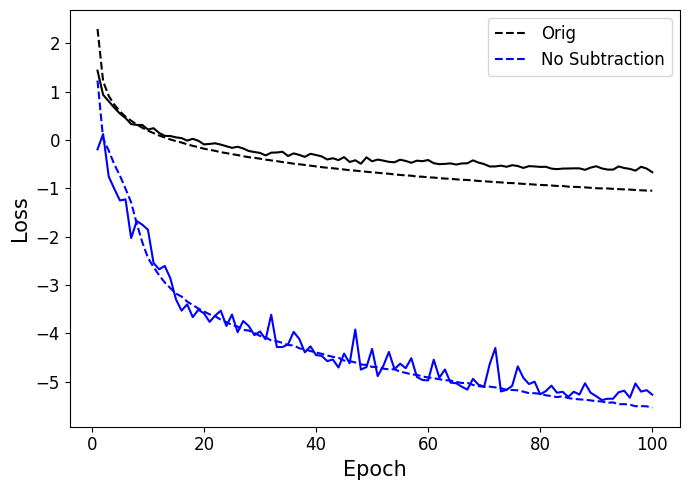

In [4]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
#Plotting loss evolution:
def plot_loss_evolution(directory_to_save_model,fig=None,label=None,indx=0):
    color_list = ['k','blue','darkred']
    loss_db = pd.read_csv(directory_to_save_model+'/loss_function_db.csv')
    pl.plot(loss_db['epoch'],loss_db['loss'],'--',c=color_list[indx],label=label)
    pl.plot(loss_db['epoch'],loss_db['val_loss'],'-',c=color_list[indx],label='_nolegend_')
    pl.xlabel('Epoch',fontsize=15)
    pl.ylabel('Loss',fontsize=15) 
    pl.tick_params(labelsize=12)
    pl.tight_layout()
#    pl.ylim(-6,5)
    if label is not None: pl.legend(fontsize=12)
    else: pl.legend(['Training Loss','Validation Loss'])
    if fig is None: pl.show()

#assert ask padma NOW about her infinite loss functions - may be something similar happening e.g. with
#infinite precision?
fig=pl.figure(figsize=(7,5))

# plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_12/',fig=fig,label='500k',indx=0)
# plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_15/',fig=fig,label='100k',indx=1)
# plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_16/',fig=fig,label='1m',indx=2)
# pl.ylim(-10,3)

plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_17/',fig=fig,label='Orig',indx=0)
plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_subtr/',fig=fig,label='No Subtraction',indx=1)
#plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_no_RSP/',fig=fig,label='No RSP',indx=2)
#plot_loss_evolution('/mnt/extraspace/hollowayp/paltas_data/Example_LP_17_100k/',fig=fig,label='100k',indx=2)
pl.show()

Plotting from npy files


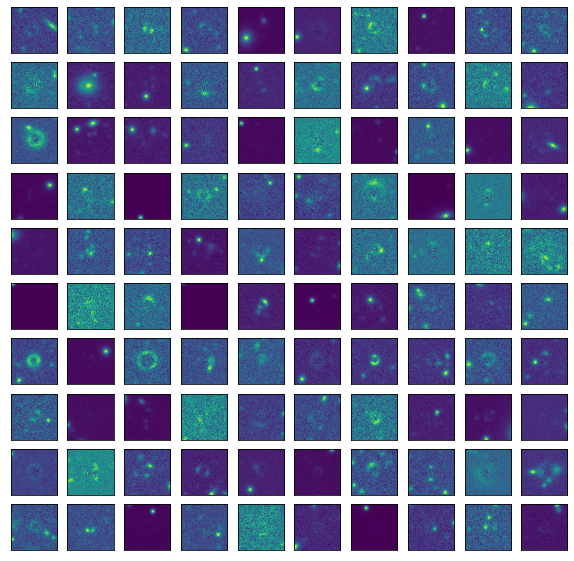

In [7]:
from plot_image_collage import plot_collage
plot_collage(f'{test_directory}/test_high_mag/',10,10)#,0,1)

In [661]:
meta_db = pd.read_csv('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/test/metadata.csv')
npy_test = glob.glob(f'{test_directory}/test/*npy')
for ii in range(len(meta_db)):
    im_number = meta_db['Catalogue_Index'][ii]
    if meta_db['Magnification'][ii]>=3:
        image_i = np.load(f'{test_directory}/test/image_'+f'{ii}'.zfill(7)+'.npy')
        np.save(f'{test_directory}/test_high_mag/image_'+f'{ii}'.zfill(7)+'.npy',image_i)

In [656]:
np.save?

Plotting from npy files


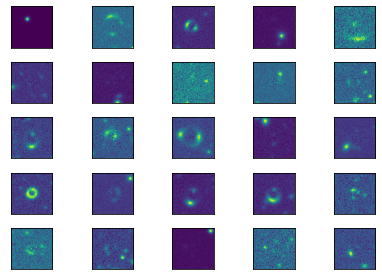

In [642]:
from plot_image_collage import plot_collage
plot_collage('/mnt/extraspace/hollowayp/paltas_data/Example_LP_14/test',5,5)
plot_collage?

# Results
We plot the results of the hierarchical inference here: the ground-truth is plotted as solid black lines, along with the population posterior 

In [ ]:
labels_kwargs = {'fontsize':20}
hist_kwargs = {'density':False,'color':'orange','lw':3}
fig,ax = pl.subplots(len(learning_params),len(learning_params),figsize=(3*len(learning_params),3*len(learning_params)))

f = 10 #Bounds of corner plot, in units of sigma

corner.corner(chain,
                labels=['$\mu_{'+elem+'}$' for elem in corner_param_print],
                range=[(prior_db_indx.loc[elem]['mean']-f*prior_db_indx.loc[elem]['std'],
                        prior_db_indx.loc[elem]['mean']+f*prior_db_indx.loc[elem]['std']) for elem in learning_params],
                fig=fig,
                show_titles=False,
                plot_datapoints=True,
                label_kwargs=labels_kwargs,\
                levels=[0.68,0.95],
                color='orange',
                fill_contours=True,
                hist_kwargs=hist_kwargs,
                title_fmt='.2f',\
                #truths=[1.1,0,0,0,0,0,0],
                truth_color='k',\
                max_n_ticks=3,
                bins=50,
                s=100
                )

sig_learning_params = np.array(prior_db['std'])#np.array([0.15,0.05,0.05,0.1,0.1,0.1,0.16,0.16])
loc_learning_params = np.array(prior_db['mean'])#np.array([1.1,0,0,2,0,0,0,0])
for i in range(len(learning_params)):
    for j in range(len(learning_params)):
        ax[i,j].set_xlim((loc_learning_params-f*sig_learning_params)[j],(loc_learning_params+f*sig_learning_params)[j])
        if i!=j:
            ax[i,j].set_ylim((loc_learning_params-f*sig_learning_params)[i],(loc_learning_params+f*sig_learning_params)[i])

pl.tight_layout()
pl.show()

# Endnote
We have now 1) generated simulated lensed images, 2) trained a neural network to model these images, 3) applied the trained network to a different set of images and 4) run hierarchical inference to infer population-level parameters.\
You may note that the final results could be improved - the configuration settings used here were chosen for speed rather than precision. For science-level results, the following should be changed:
1) Increase the training-set size for the neural network,
2) Increase the number of epochs the network trains for,
3) Increase the number of iterations (and burn-in) of the MCMC used for hierarchical inference.


In [ ]:
import sys
sys.path.append(folder_a)
from python_file_a import 